# **Notebook 4: Feature Engineering**

## Objectives

* Undertake feature engineering for regression features

## Tasks

* Load and inspect the data prepared during data cleaning
* Data exploration and analysis
* Feature engineering
* Conclusion and steps forward

## Inputs

* outputs/datasets/cleaned/train_set.csv
* outputs/datasets/cleaned/test_set.csv


## Outputs

* A list of variables that will be engineered

## Additional Comments

* This notebook was informed and guided by the steps provided in the Customer Churn Walkthrough Porject.

* We intend to explore the data using the CRISP-DM Data methodology.


---

# Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/Housing-Predictive-Analytics/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/Housing-Predictive-Analytics'

## Load Data

Load the train dataset

In [4]:
import pandas as pd
train_set_path = "outputs/datasets/cleaned/train_set.csv"
train_set = pd.read_csv(train_set_path)
train_set.head(3)

1stFlrSF  2ndFlrSF  BedroomAbvGr  BsmtExposure  BsmtFinSF1  BsmtFinType1  \
0      1828         0             0             0          48             7   
1       894         0             2             3           0             6   
2       964         0             2             3         713             0   

   BsmtUnfSF  GarageArea  GarageFinish  GarageYrBlt  ...  LotArea  \
0       1774         774             3         2007  ...    11694   
1        894         308             4         1962  ...     6600   
2        163         432             3         1921  ...    13360   

   LotFrontage  MasVnrArea  OpenPorchSF  OverallCond  OverallQual  \
0           90         452          108            5            9   
1           60           0            0            5            5   
2           80           0            0            7            5   

   TotalBsmtSF  YearBuilt  YearRemodAdd  SalePrice  
0         1822       2007          2007     314813  
1          894       1962          1962     109500  
2          876       1921          2006     163500  

[3 rows x 22 columns]

Load the test dataset

In [5]:
test_set_path = "outputs/datasets/cleaned/test_set.csv"
test_set = pd.read_csv(test_set_path)
test_set.head(3)

1stFlrSF  2ndFlrSF  BedroomAbvGr  BsmtExposure  BsmtFinSF1  BsmtFinType1  \
0      2515         0             4             3        1219             5   
1       958       620             3             3         403             1   
2       979       224             3             3         185             3   

   BsmtUnfSF  GarageArea  GarageFinish  GarageYrBlt  ...  LotArea  \
0        816         484             4         1975  ...    32668   
1        238         240             3         1941  ...     9490   
2        524         352             3         1950  ...     7015   

   LotFrontage  MasVnrArea  OpenPorchSF  OverallCond  OverallQual  \
0           69           0            0            3            6   
1           79           0            0            7            6   
2           69         161            0            4            5   

   TotalBsmtSF  YearBuilt  YearRemodAdd  SalePrice  
0         2035       1957          1975     200624  
1          806       1941          1950     133000  
2          709       1950          1950     110000  

[3 rows x 22 columns]

---

## Feature Engineering

### Analysis and Transformation Functions

* Below I intend to use a unique function adapated from the feature-engineering lesson, to initiate feature engineering.

In [6]:
from feature_engine import transformation as vt
from feature_engine.outliers import Winsorizer
from feature_engine.encoding import OrdinalEncoder
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

def FeatureEngineeringAnalysis(df,analysis_type=None):
  """
  - A fast way for feature engineering numerical and categorical variables
  so as to decide which transformation can better transform the distribution shape 
  - Upon transformation, use a reporting tool, like ydata-profiling, to evaluate the distributions.

  """
  check_missing_values(df)
  allowed_types= ['numerical', 'ordinal_encoder',  'outlier_winsorizer']
  check_user_entry_on_analysis_type(analysis_type, allowed_types)
  list_column_transformers = define_list_column_transformers(analysis_type)
  
  
  # Looping in of each variable and engineer the data according to the analysis type
  df_feat_eng = pd.DataFrame([])
  for column in df.columns:
    # create additional columns (column_method) to apply the methods
    df_feat_eng = pd.concat([df_feat_eng, df[column]], axis=1)
    for method in list_column_transformers:
      df_feat_eng[f"{column}_{method}"] = df[column]
      
    # Apply transformers in respectives column_transformers
    df_feat_eng,list_applied_transformers = apply_transformers(analysis_type, df_feat_eng, column)

    # For each variable, assess how the transformations have performed
    transformer_evaluation(column, list_applied_transformers, analysis_type, df_feat_eng)

  return df_feat_eng


def check_user_entry_on_analysis_type(analysis_type, allowed_types):
  ### Check analyis type
  if analysis_type == None:
    raise SystemExit(f"Its necessary to pass analysis_type parameter as one of the following options: {allowed_types}")
  if analysis_type not in allowed_types:
      raise SystemExit(f"analysis_type argument should be shown as one of these options: {allowed_types}")


def check_missing_values(df):
  if df.isna().sum().sum() != 0:
    raise SystemExit(
        f"There is a missing value in your dataset. Please correct that before getting into feature engineering.")


def define_list_column_transformers(analysis_type):
  ### The suffix colummns to be set acording to analysis_type
  if analysis_type=='numerical':
    list_column_transformers = ["log_e", "log_10", "reciprocal", "power", "box_cox", "yeo_johnson"]
  
  elif analysis_type=='ordinal_encoder':
    list_column_transformers = ["ordinal_encoder"]

  elif analysis_type=='outlier_winsorizer':
    list_column_transformers = ['iqr']

  return list_column_transformers

def apply_transformers(analysis_type, df_feat_eng, column):


  for col in df_feat_eng.select_dtypes(include='category').columns:
    df_feat_eng[col] = df_feat_eng[col].astype('object')


  if analysis_type=='numerical':
    df_feat_eng,list_applied_transformers = FeatEngineering_Numerical(df_feat_eng,column)
  
  elif analysis_type=='outlier_winsorizer':
    df_feat_eng,list_applied_transformers = FeatEngineering_OutlierWinsorizer(df_feat_eng,column)

  elif analysis_type=='ordinal_encoder':
    df_feat_eng,list_applied_transformers = FeatEngineering_CategoricalEncoder(df_feat_eng,column)

  return df_feat_eng,list_applied_transformers

def transformer_evaluation(column, list_applied_transformers, analysis_type, df_feat_eng):
  # For each variable, assess how the transformations are performing
  print(f"* Variable Analyzed: {column}")
  print(f"* Applied transformation: {list_applied_transformers} \n")
  transformer_column = column + '_' + analysis_type
  
  for col in [column] + list_applied_transformers:
    
    if analysis_type!='ordinal_encoder':
      DiagnosticPlots_Numerical(df_feat_eng, col)
    
    else:
      print(f"{df_feat_eng.set_index(transformer_column).groupby([transformer_column, column]).size()} \n")
      if col == column: 
        DiagnosticPlots_Categories(df_feat_eng, col)
      else:
        DiagnosticPlots_Numerical(df_feat_eng, col)

    print("\n")


def DiagnosticPlots_Categories(df_feat_eng, col):
  plt.figure(figsize=(4, 3))
  sns.countplot(data=df_feat_eng, x=col,palette=['#432371'],order = df_feat_eng[col].value_counts().index)
  plt.xticks(rotation=90) 
  plt.suptitle(f"{col}", fontsize=30,y=1.05)        
  plt.show()
  print("\n")


def DiagnosticPlots_Numerical(df, variable):
  fig, axes = plt.subplots(1, 3, figsize=(12, 4))
  sns.histplot(data=df, x=variable, kde=True,element="step",ax=axes[0]) 
  stats.probplot(df[variable], dist="norm", plot=axes[1])
  sns.boxplot(x=df[variable],ax=axes[2])
  
  axes[0].set_title('Histogram')
  axes[1].set_title('QQ Plot')
  axes[2].set_title('Boxplot')
  fig.suptitle(f"{variable}", fontsize=30,y=1.05)
  plt.tight_layout()
  plt.show()


def FeatEngineering_CategoricalEncoder(df_feat_eng,column):
  list_methods_worked = []
  try:  
    encoder= OrdinalEncoder(encoding_method='arbitrary', variables = [f"{column}_ordinal_encoder"])
    df_feat_eng = encoder.fit_transform(df_feat_eng)
    list_methods_worked.append(f"{column}_ordinal_encoder")
  
  except: 
    df_feat_eng.drop([f"{column}_ordinal_encoder"],axis=1,inplace=True)
    
  return df_feat_eng,list_methods_worked


def FeatEngineering_OutlierWinsorizer(df_feat_eng,column):
  list_methods_worked = []

  ### Winsorizer iqr
  try: 
    disc=Winsorizer(
        capping_method='iqr', tail='both', fold=1.5, variables = [f"{column}_iqr"])
    df_feat_eng = disc.fit_transform(df_feat_eng)
    list_methods_worked.append(f"{column}_iqr")
  except: 
    df_feat_eng.drop([f"{column}_iqr"],axis=1,inplace=True)


  return df_feat_eng,list_methods_worked


def FeatEngineering_Numerical(df_feat_eng,column):

  list_methods_worked = []

  ### LogTransformer base e
  try: 
    lt = vt.LogTransformer(variables = [f"{column}_log_e"])
    df_feat_eng = lt.fit_transform(df_feat_eng)
    list_methods_worked.append(f"{column}_log_e")
  except: 
    df_feat_eng.drop([f"{column}_log_e"],axis=1,inplace=True)

  ### LogTransformer base 10
  try: 
    lt = vt.LogTransformer(variables = [f"{column}_log_10"],base='10')
    df_feat_eng = lt.fit_transform(df_feat_eng)
    list_methods_worked.append(f"{column}_log_10")
  except: 
    df_feat_eng.drop([f"{column}_log_10"],axis=1,inplace=True)

  ### ReciprocalTransformer
  try:
    rt = vt.ReciprocalTransformer(variables = [f"{column}_reciprocal"])
    df_feat_eng =  rt.fit_transform(df_feat_eng)
    list_methods_worked.append(f"{column}_reciprocal")
  except:
    df_feat_eng.drop([f"{column}_reciprocal"],axis=1,inplace=True)


    ### PowerTransformer
  try:
    pt = vt.PowerTransformer(variables = [f"{column}_power"])
    df_feat_eng = pt.fit_transform(df_feat_eng)
    list_methods_worked.append(f"{column}_power")
  except:
    df_feat_eng.drop([f"{column}_power"],axis=1,inplace=True)

  ### BoxCoxTransformer
  try:
    bct = vt.BoxCoxTransformer(variables = [f"{column}_box_cox"])
    df_feat_eng = bct.fit_transform(df_feat_eng)
    list_methods_worked.append(f"{column}_box_cox")
  except:
    df_feat_eng.drop([f"{column}_box_cox"],axis=1,inplace=True)

  ### YeoJohnsonTransformer
  try:
    yjt = vt.YeoJohnsonTransformer(variables = [f"{column}_yeo_johnson"])
    df_feat_eng = yjt.fit_transform(df_feat_eng)
    list_methods_worked.append(f"{column}_yeo_johnson")
  except:
        df_feat_eng.drop([f"{column}_yeo_johnson"],axis=1,inplace=True)

  return df_feat_eng,list_methods_worked

---

### The Transformers to be used
* These are the transformer that will be used and will be applied according to this order:

  * Categorical Encoding
  * Numerical Transformation
  * Smart Correlation Selection

### Categorical Encoding

* Replace categorical data with ordinal numbers.

1. Declare a variable with the categorical variable names

In [7]:
categorical_variables = list(train_set.select_dtypes(['object','category']).columns)
categorical_variables

[]

---

2. Create a dataframe from a subset of the Train set using the variable above.

In [8]:
df_categorical = train_set[categorical_variables].copy()
df_categorical.head()

Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, 4]

---

3. Apply the transformation to the variables and assess the distribution in order to select a suitable method for each variable

In [9]:
df_categorical_engineered = FeatureEngineeringAnalysis(df=df_categorical, analysis_type='ordinal_encoder')

#### Analysis of plots
* The transformation from categorical to numerical is effective

## Numerical Transformation

1. Declare a variable with the numerical variable names

In [10]:
numerical_variables = list(train_set.select_dtypes(['int64','float64']).columns)
numerical_variables

['1stFlrSF',
 '2ndFlrSF',
 'BedroomAbvGr',
 'BsmtExposure',
 'BsmtFinSF1',
 'BsmtFinType1',
 'BsmtUnfSF',
 'GarageArea',
 'GarageFinish',
 'GarageYrBlt',
 'GrLivArea',
 'KitchenQual',
 'LotArea',
 'LotFrontage',
 'MasVnrArea',
 'OpenPorchSF',
 'OverallCond',
 'OverallQual',
 'TotalBsmtSF',
 'YearBuilt',
 'YearRemodAdd',
 'SalePrice']

2. Create a dataframe from a subset of the Train set using the variable above

In [11]:
df_numerical = train_set[numerical_variables].copy()
df_numerical.head()

1stFlrSF  2ndFlrSF  BedroomAbvGr  BsmtExposure  BsmtFinSF1  BsmtFinType1  \
0      1828         0             0             0          48             7   
1       894         0             2             3           0             6   
2       964         0             2             3         713             0   
3      1689         0             3             3        1218             2   
4      1541         0             3             3           0             6   

   BsmtUnfSF  GarageArea  GarageFinish  GarageYrBlt  ...  LotArea  \
0       1774         774             3         2007  ...    11694   
1        894         308             4         1962  ...     6600   
2        163         432             3         1921  ...    13360   
3        350         857             2         2002  ...    13265   
4       1541         843             2         2001  ...    13704   

   LotFrontage  MasVnrArea  OpenPorchSF  OverallCond  OverallQual  \
0           90         452          108            5            9   
1           60           0            0            5            5   
2           80           0            0            7            5   
3           69         148           59            5            8   
4          118         150           81            5            7   

   TotalBsmtSF  YearBuilt  YearRemodAdd  SalePrice  
0         1822       2007          2007     314813  
1          894       1962          1962     109500  
2          876       1921          2006     163500  
3         1568       2002          2002     271000  
4         1541       2001          2002     205000  

[5 rows x 22 columns]

3. We can apply the transformation to the variables and assess their distribution in order to select a suitable method for each variable.

* Variable Analyzed: 1stFlrSF
* Applied transformation: ['1stFlrSF_log_e', '1stFlrSF_log_10', '1stFlrSF_reciprocal', '1stFlrSF_power', '1stFlrSF_box_cox', '1stFlrSF_yeo_johnson'] 



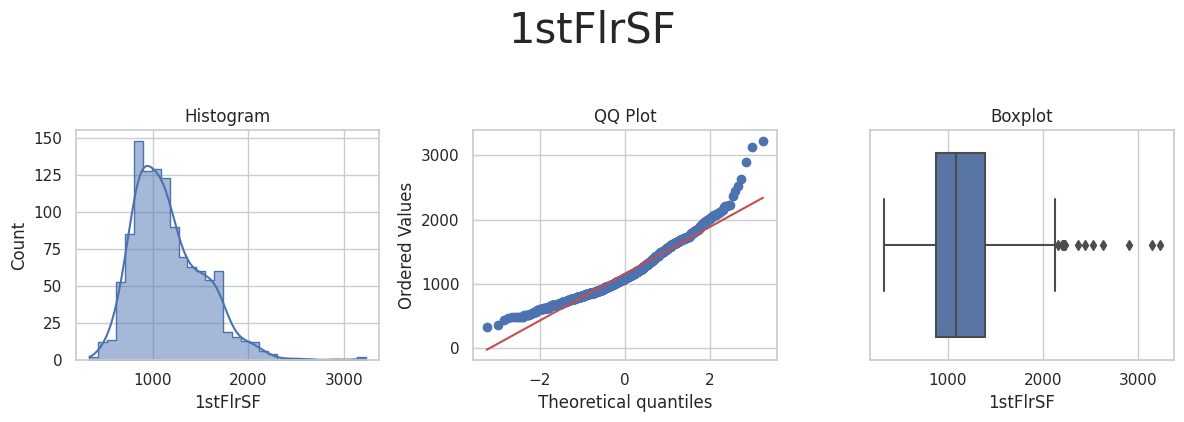

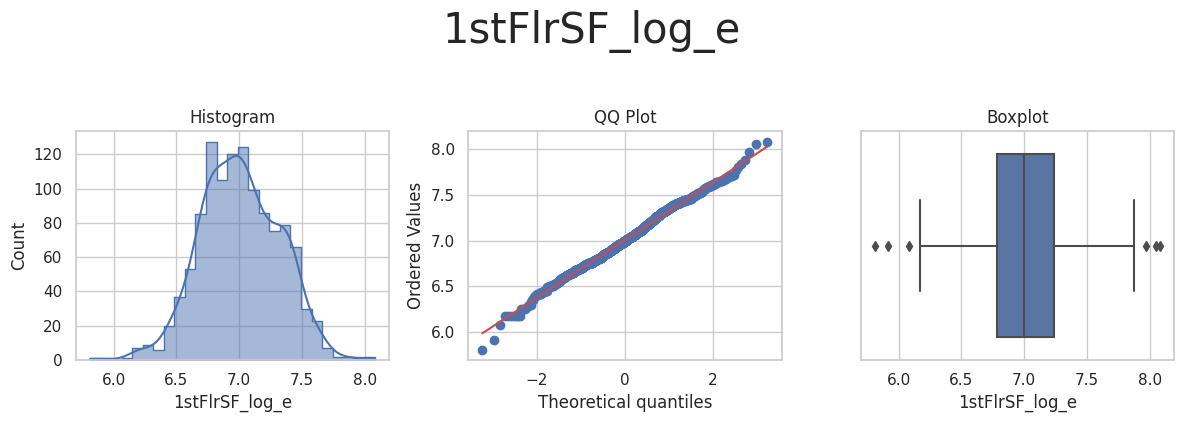

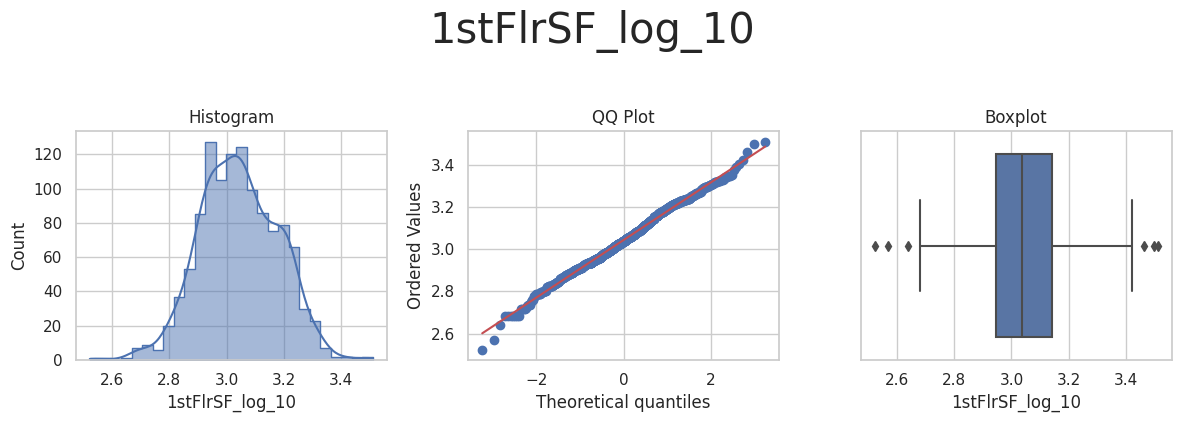

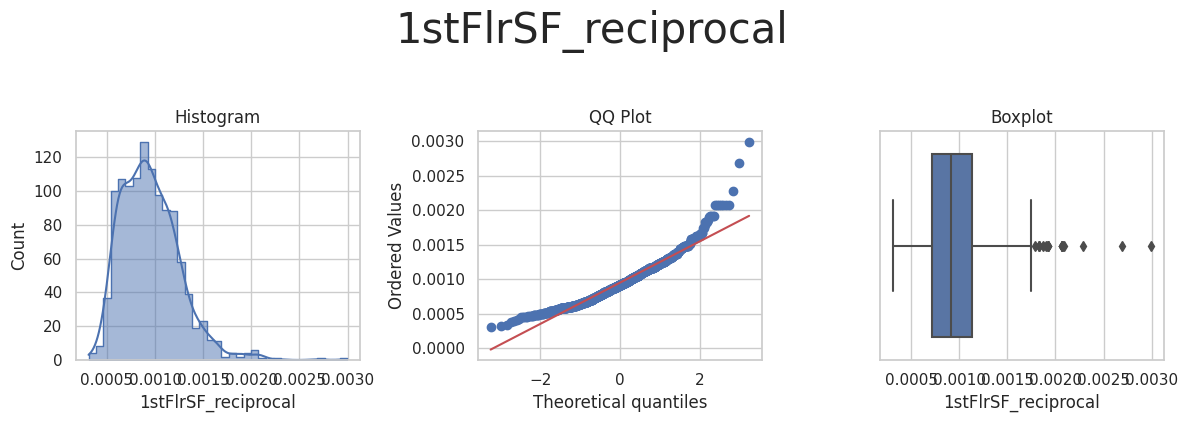

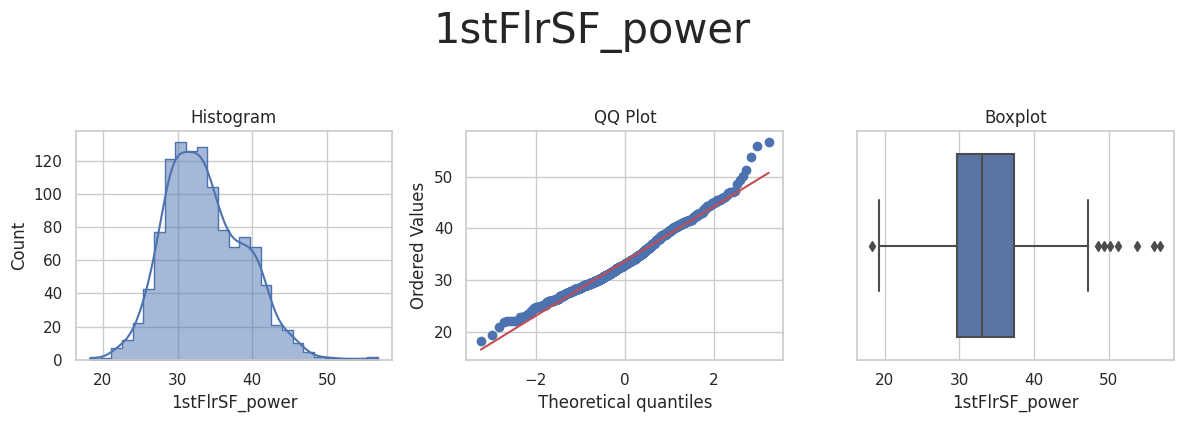

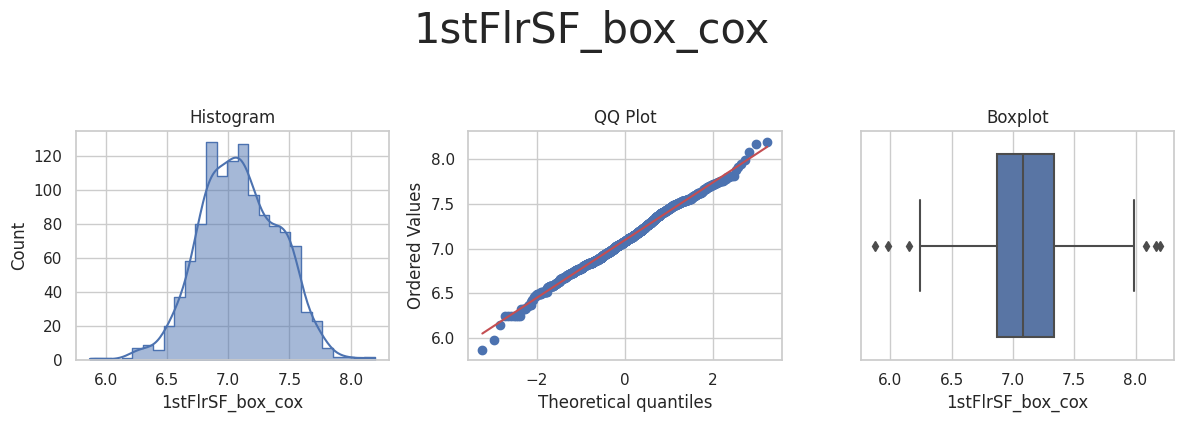

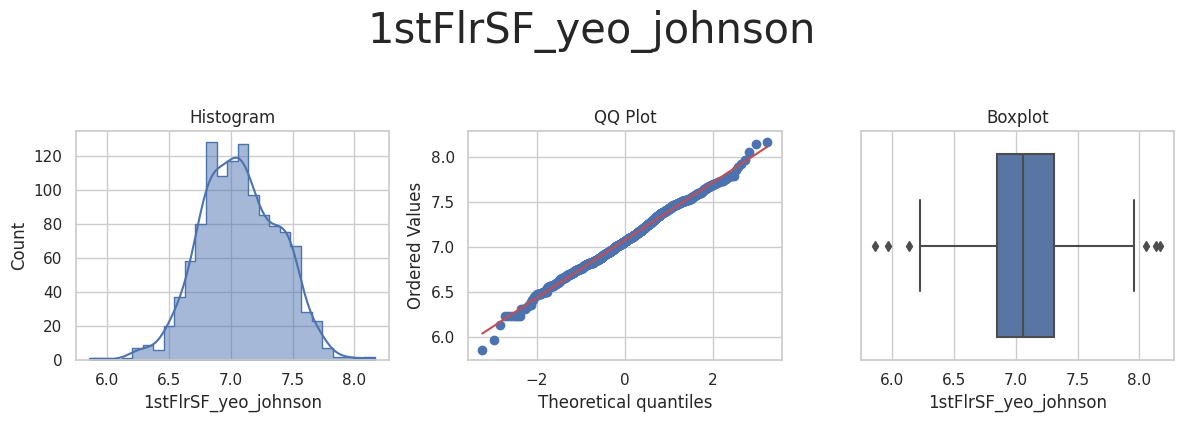



* Variable Analyzed: 2ndFlrSF
* Applied transformation: ['2ndFlrSF_power', '2ndFlrSF_yeo_johnson'] 



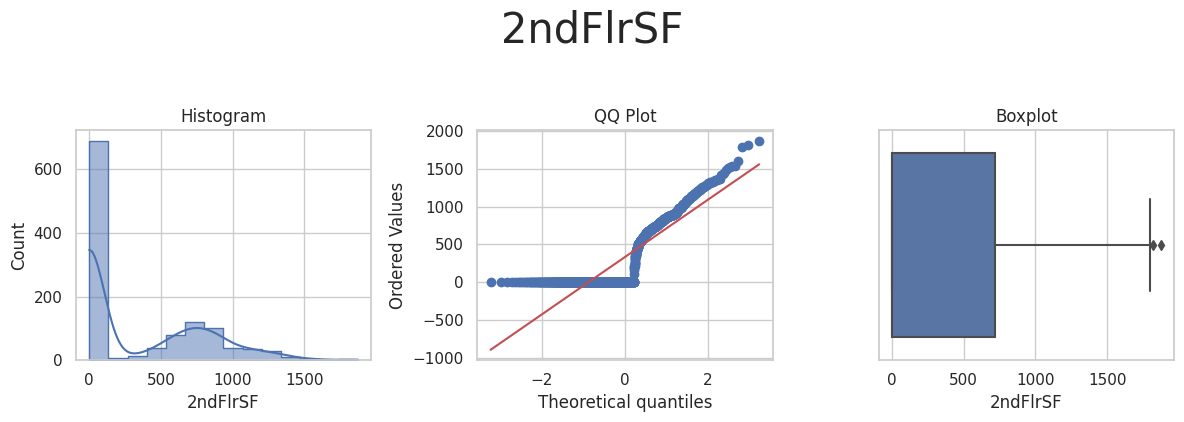

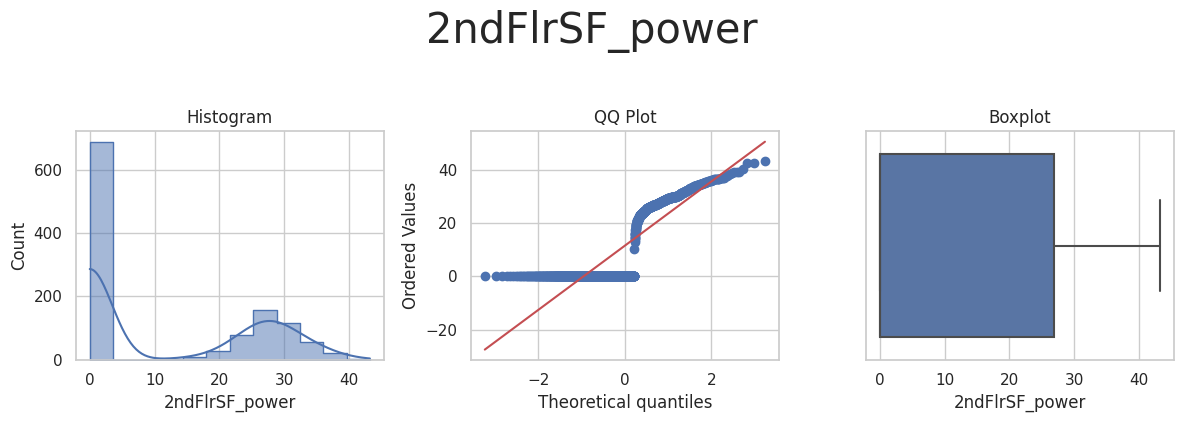

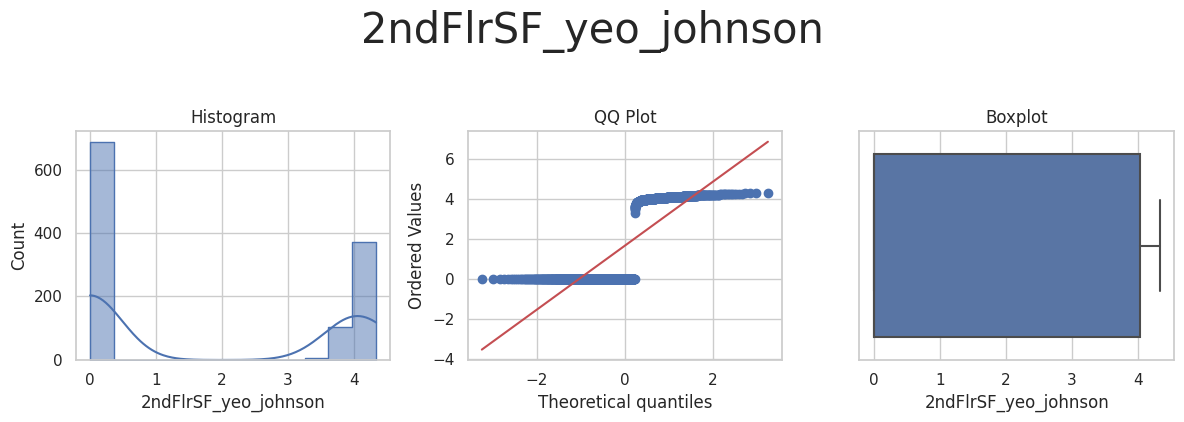



* Variable Analyzed: BedroomAbvGr
* Applied transformation: ['BedroomAbvGr_power', 'BedroomAbvGr_yeo_johnson'] 



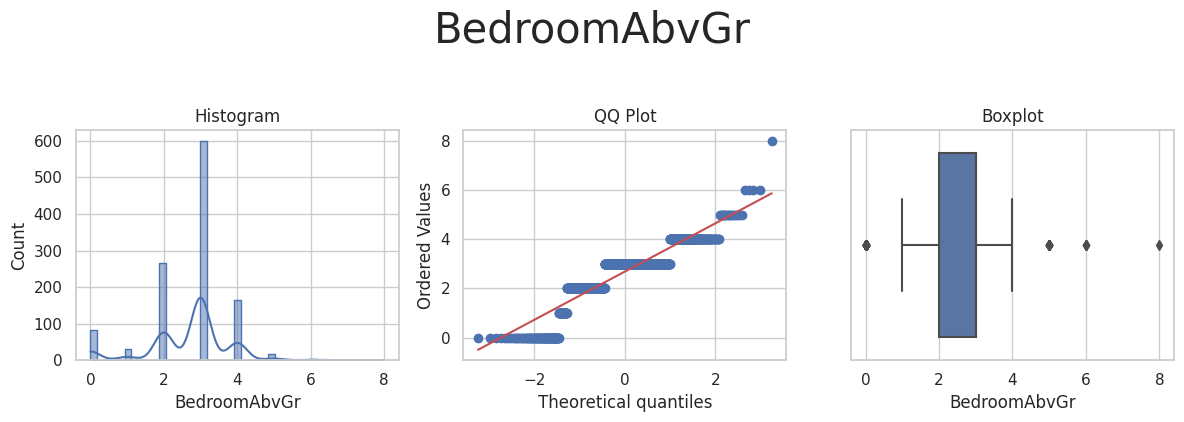

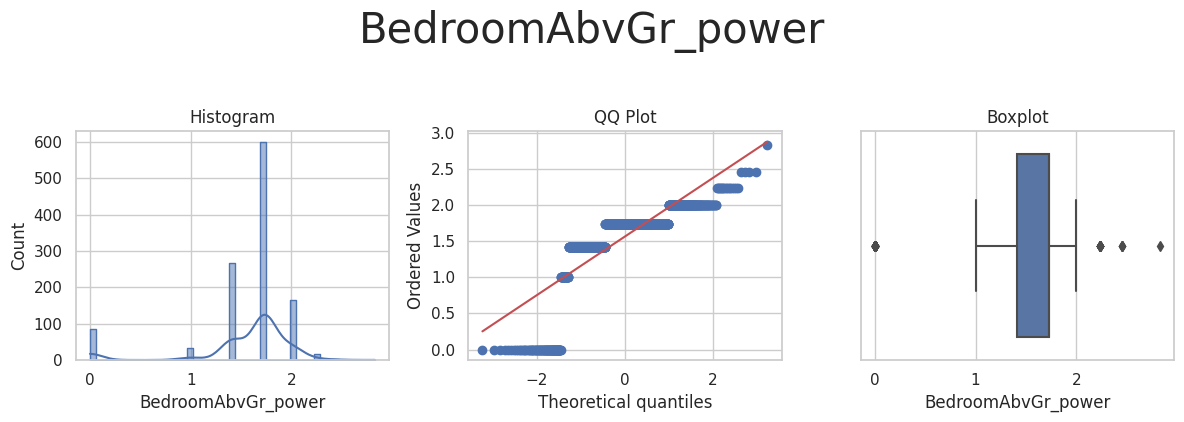

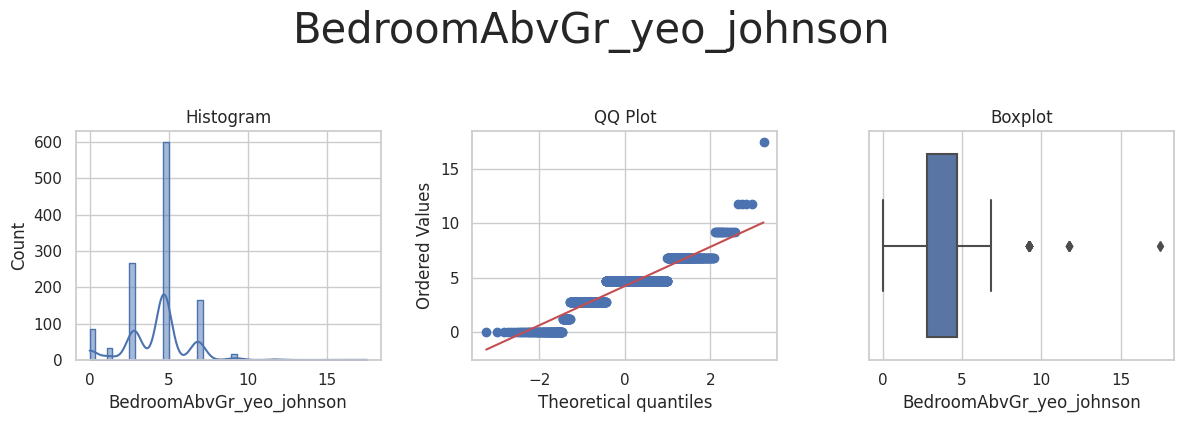



* Variable Analyzed: BsmtExposure
* Applied transformation: ['BsmtExposure_power', 'BsmtExposure_yeo_johnson'] 



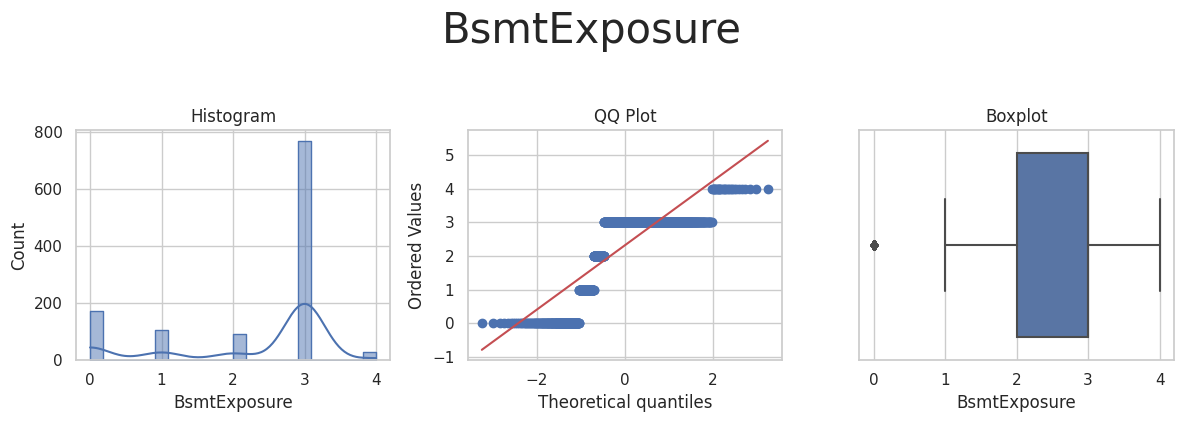

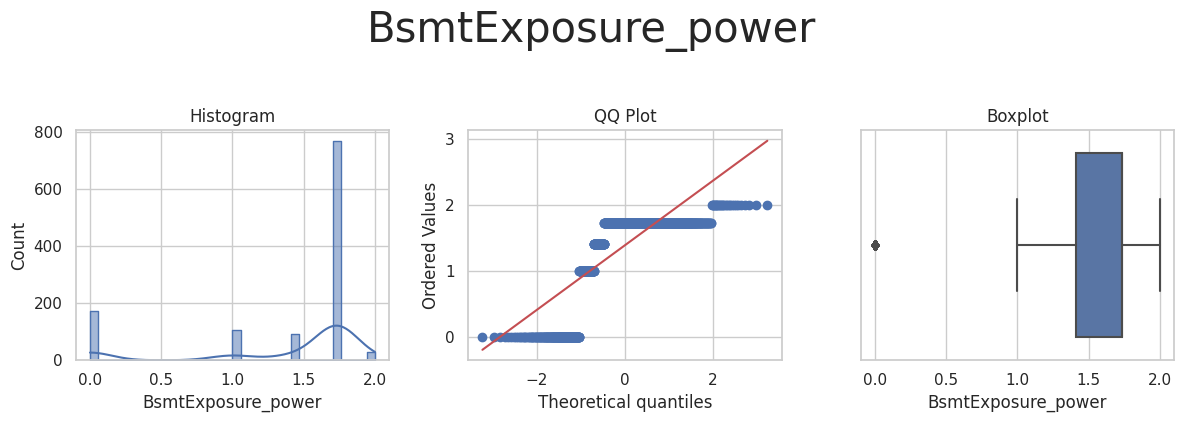

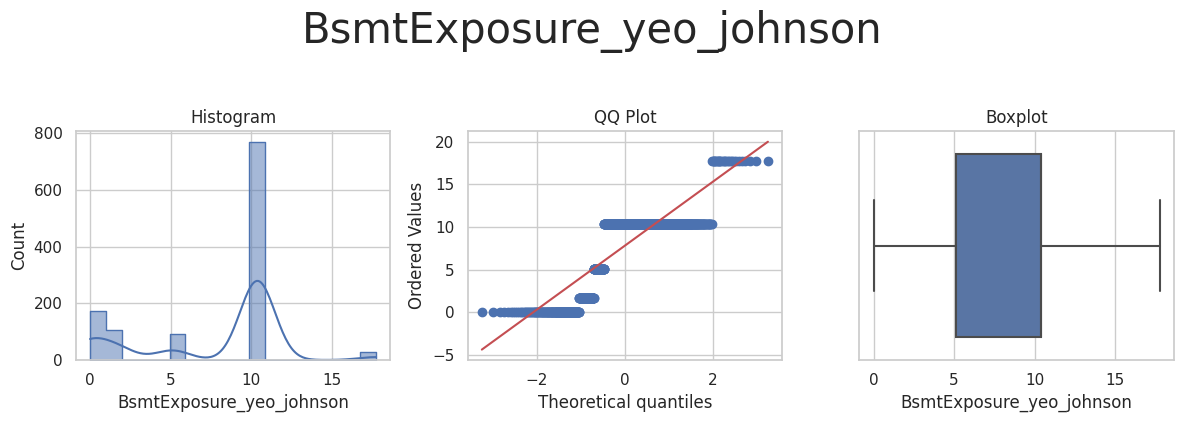



* Variable Analyzed: BsmtFinSF1
* Applied transformation: ['BsmtFinSF1_power', 'BsmtFinSF1_yeo_johnson'] 



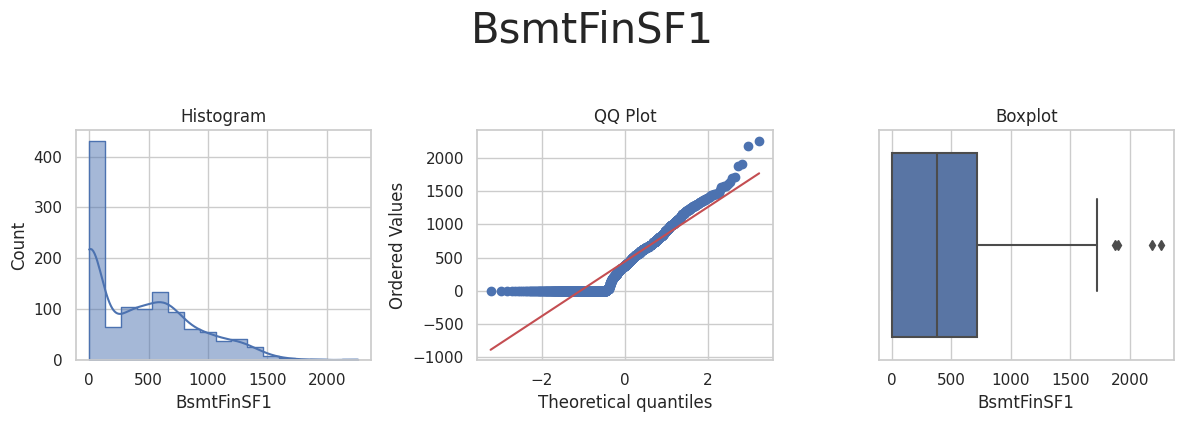

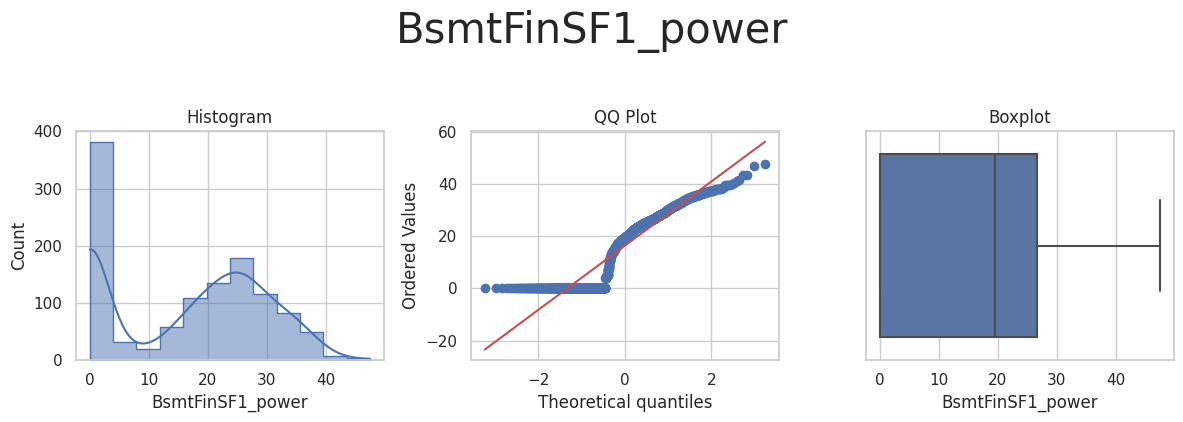

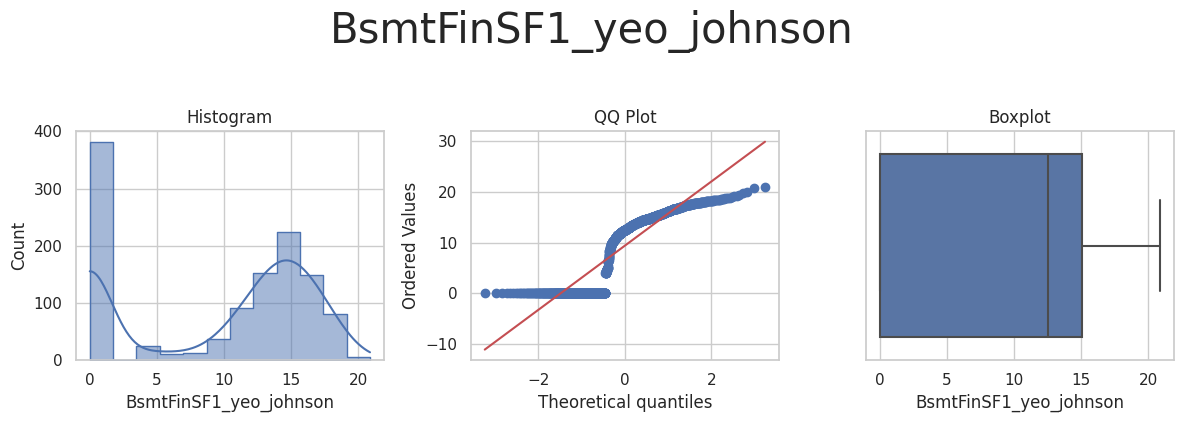



* Variable Analyzed: BsmtFinType1
* Applied transformation: ['BsmtFinType1_power', 'BsmtFinType1_yeo_johnson'] 



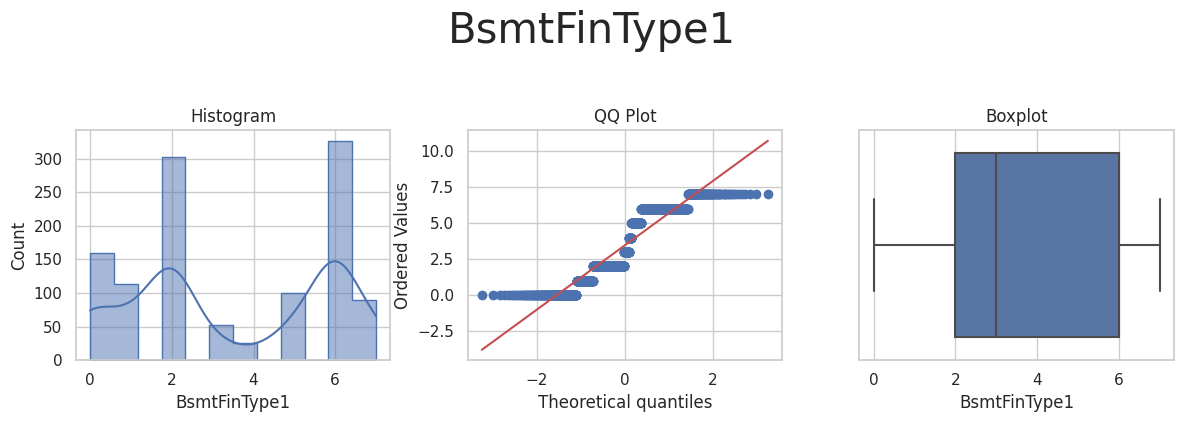

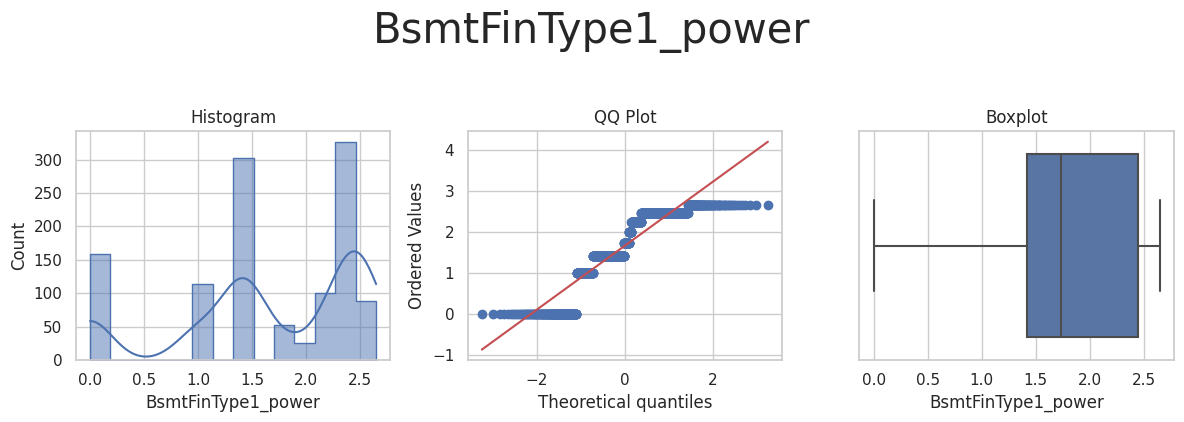

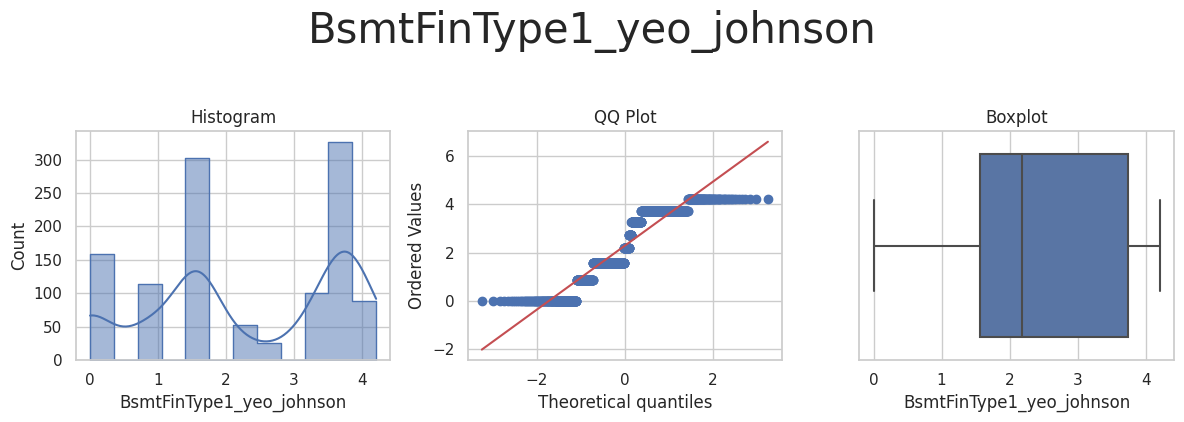



* Variable Analyzed: BsmtUnfSF
* Applied transformation: ['BsmtUnfSF_power', 'BsmtUnfSF_yeo_johnson'] 



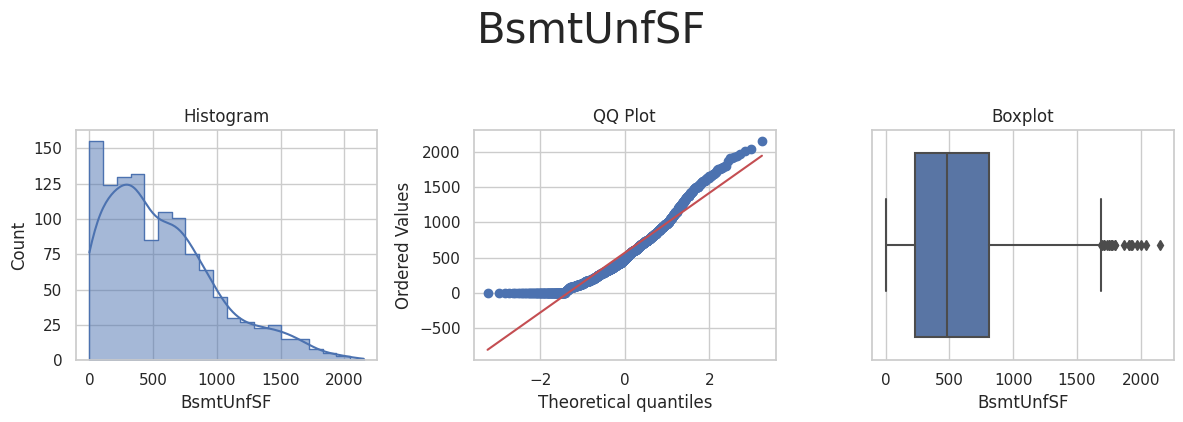

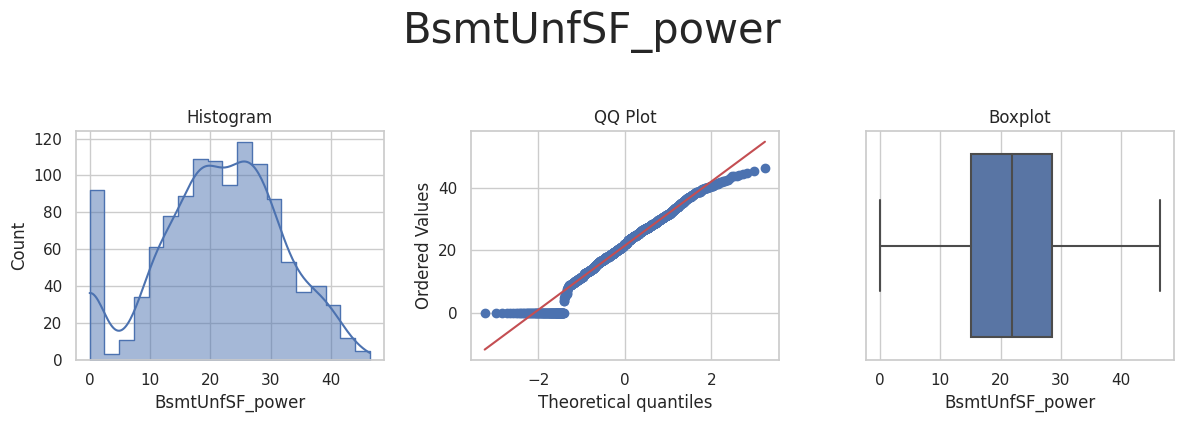

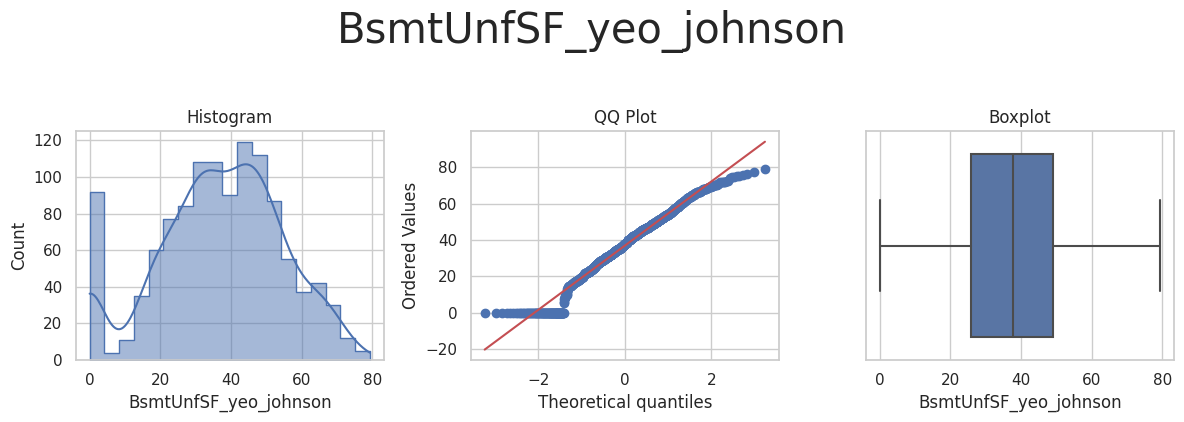



* Variable Analyzed: GarageArea
* Applied transformation: ['GarageArea_power', 'GarageArea_yeo_johnson'] 



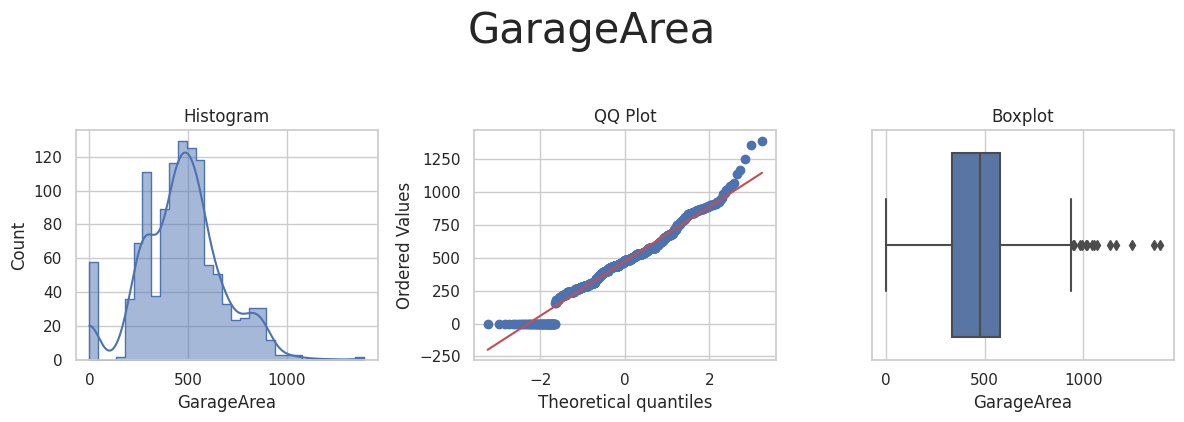

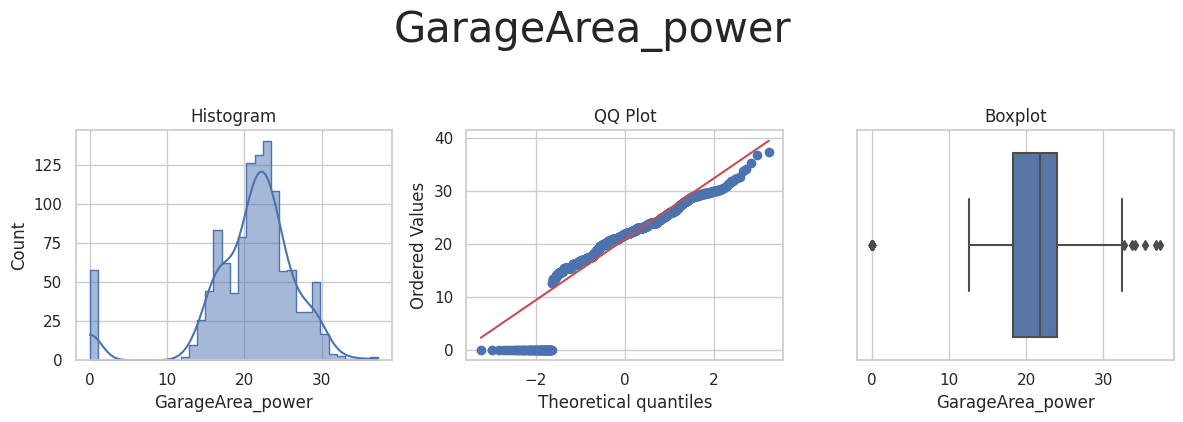

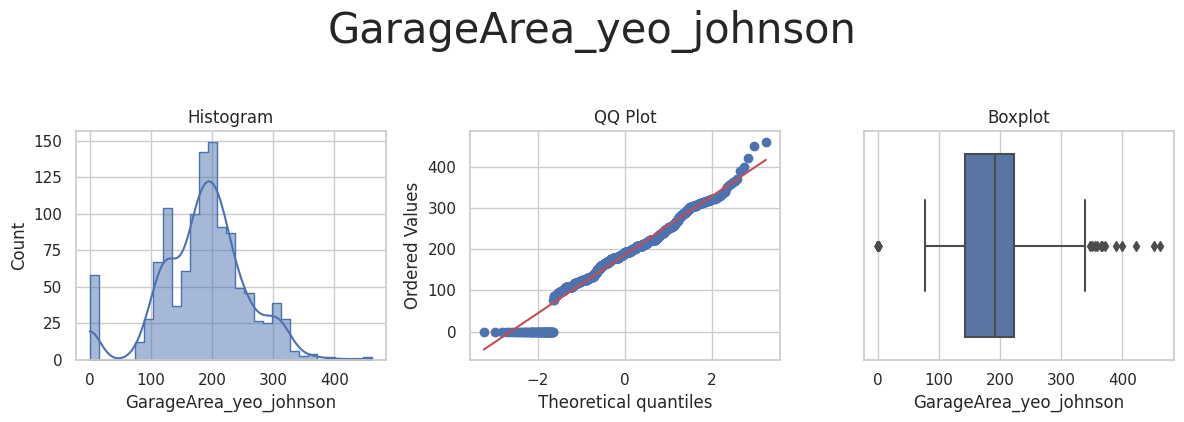



* Variable Analyzed: GarageFinish
* Applied transformation: ['GarageFinish_power', 'GarageFinish_yeo_johnson'] 



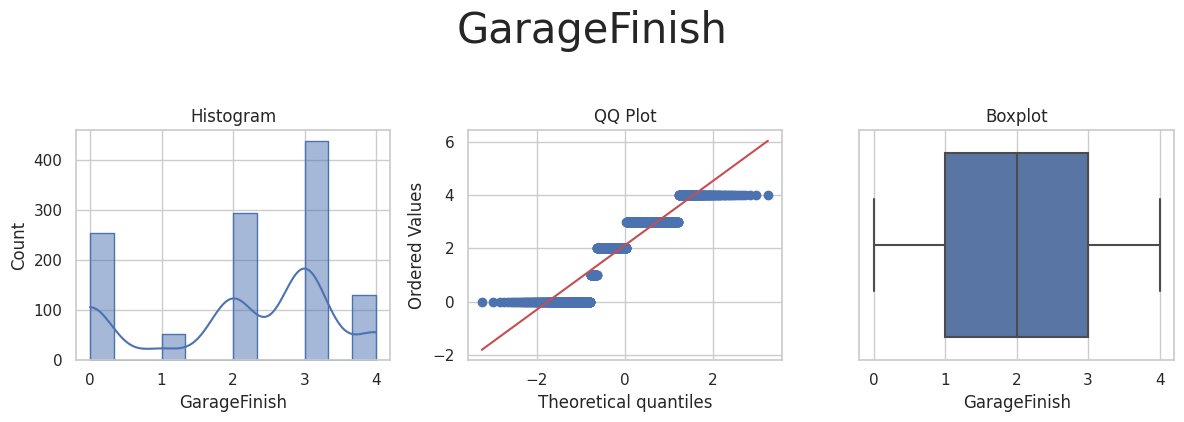

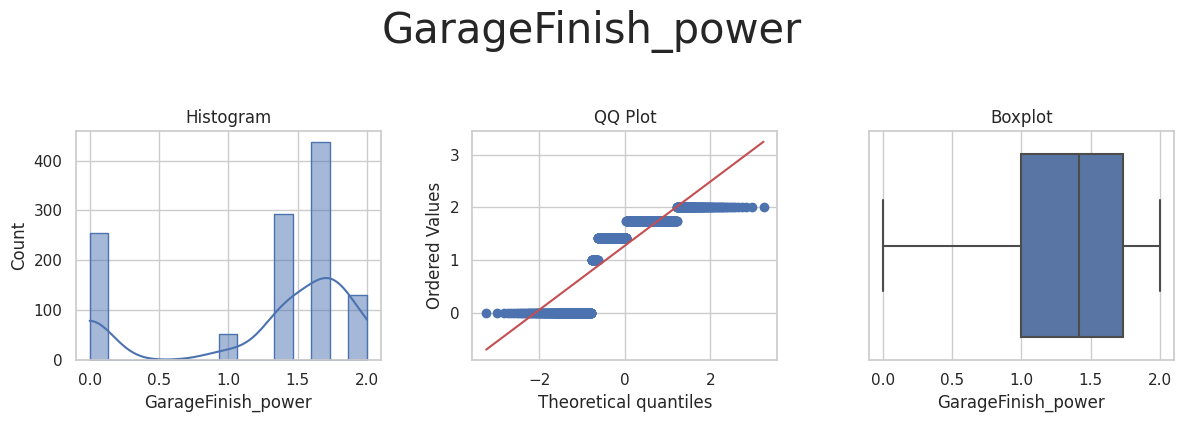

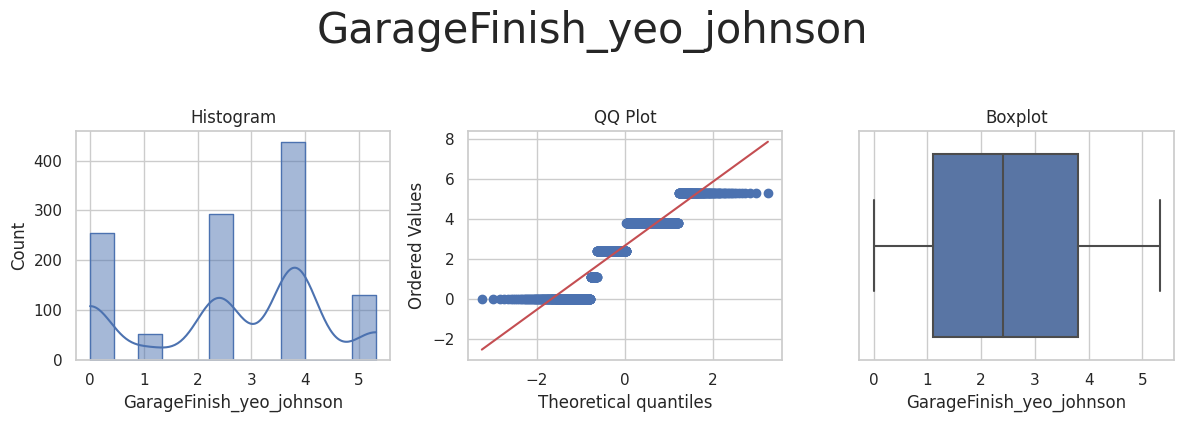



* Variable Analyzed: GarageYrBlt
* Applied transformation: ['GarageYrBlt_power', 'GarageYrBlt_yeo_johnson'] 



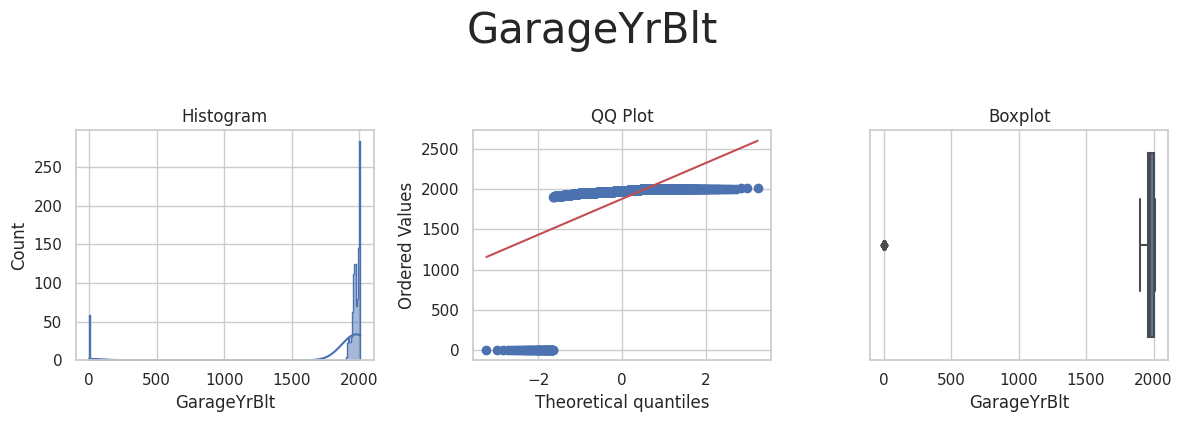

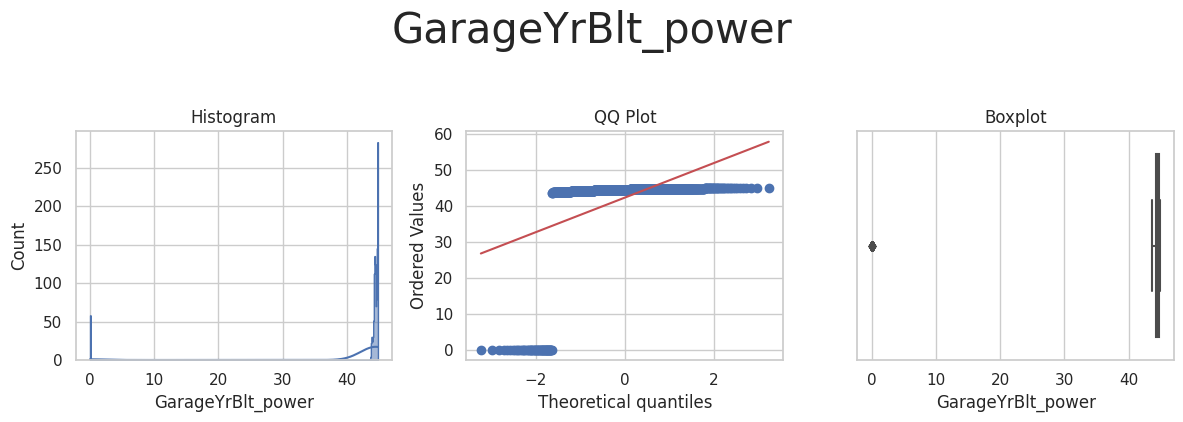

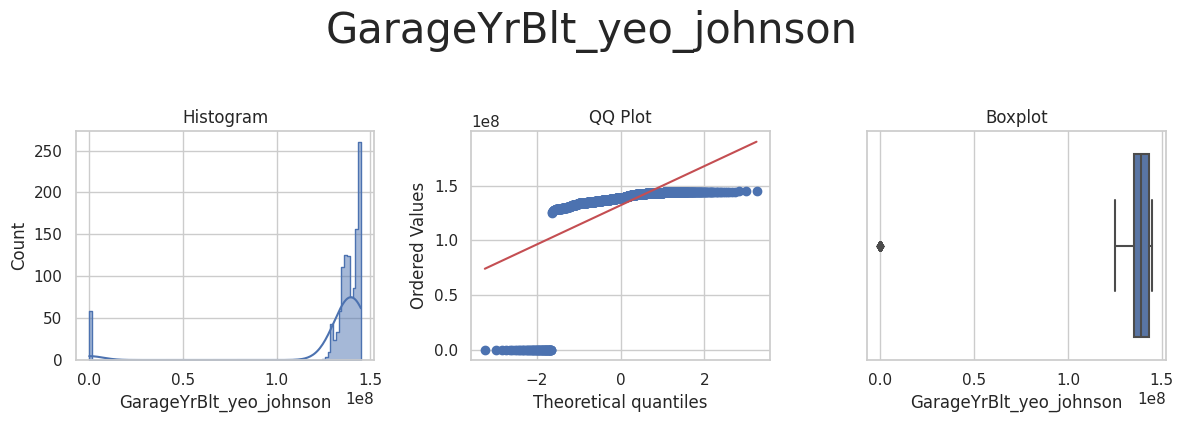



* Variable Analyzed: GrLivArea
* Applied transformation: ['GrLivArea_log_e', 'GrLivArea_log_10', 'GrLivArea_reciprocal', 'GrLivArea_power', 'GrLivArea_box_cox', 'GrLivArea_yeo_johnson'] 



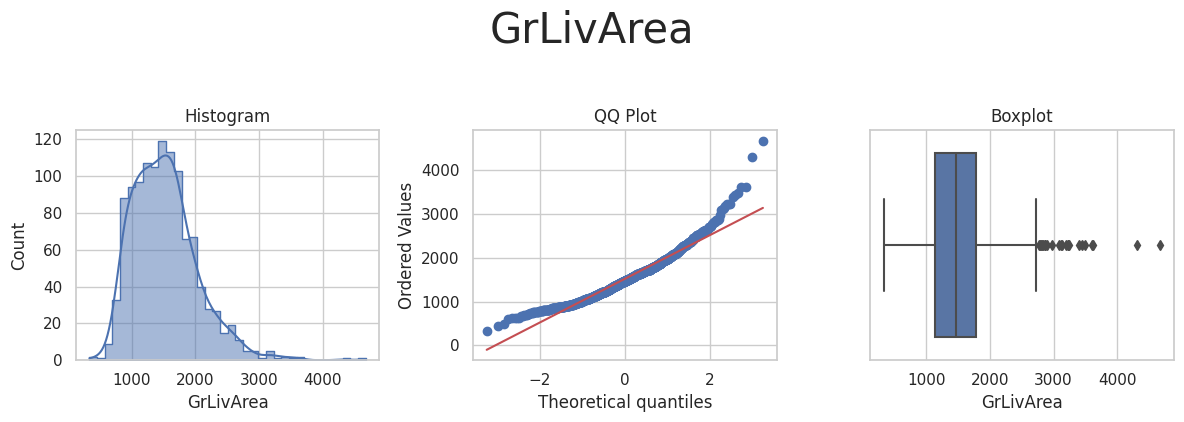

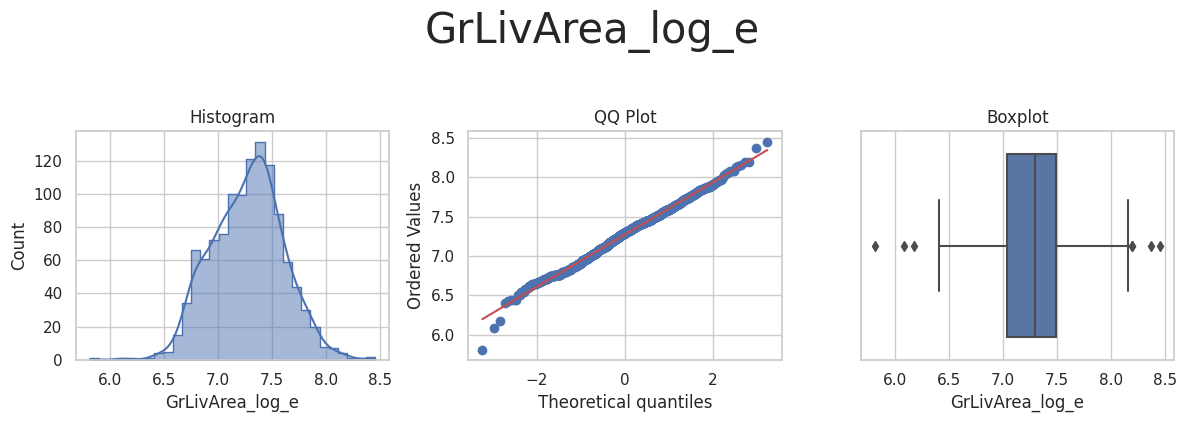

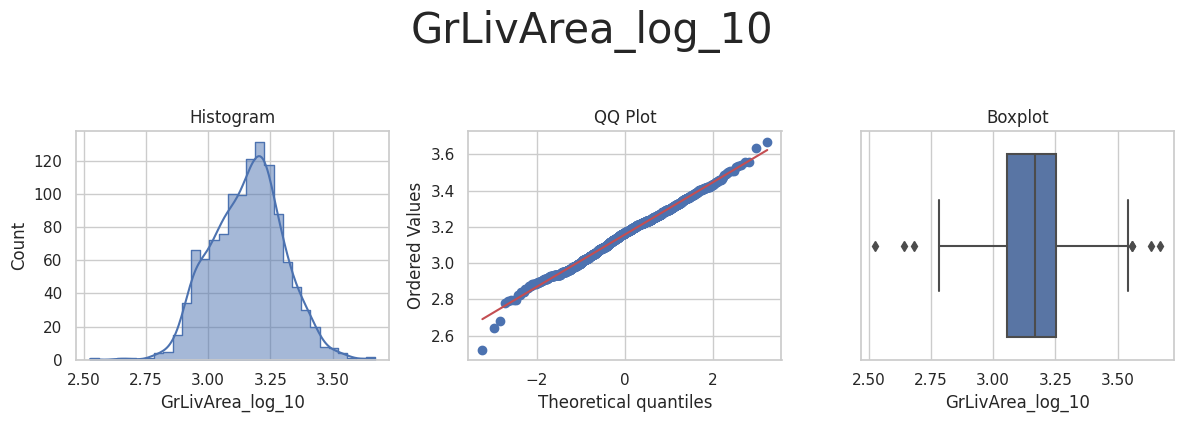

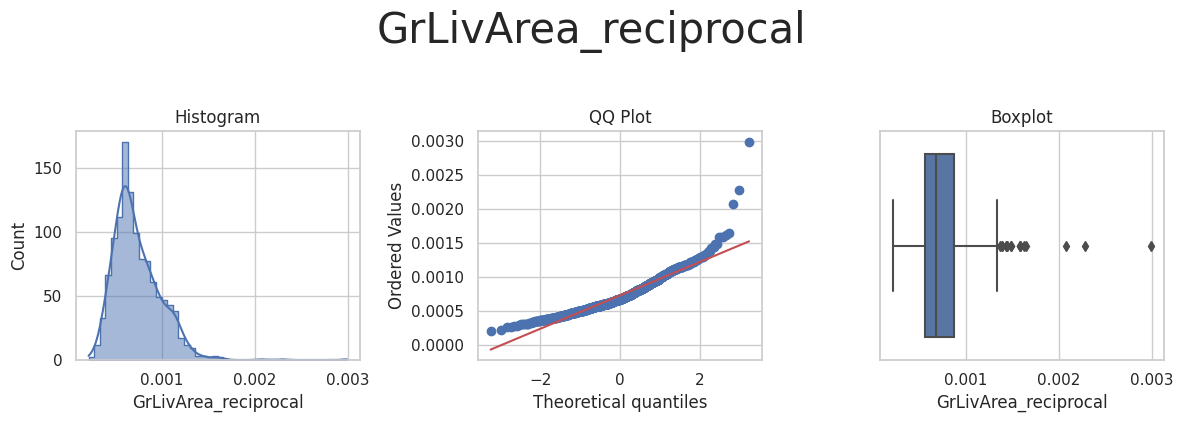

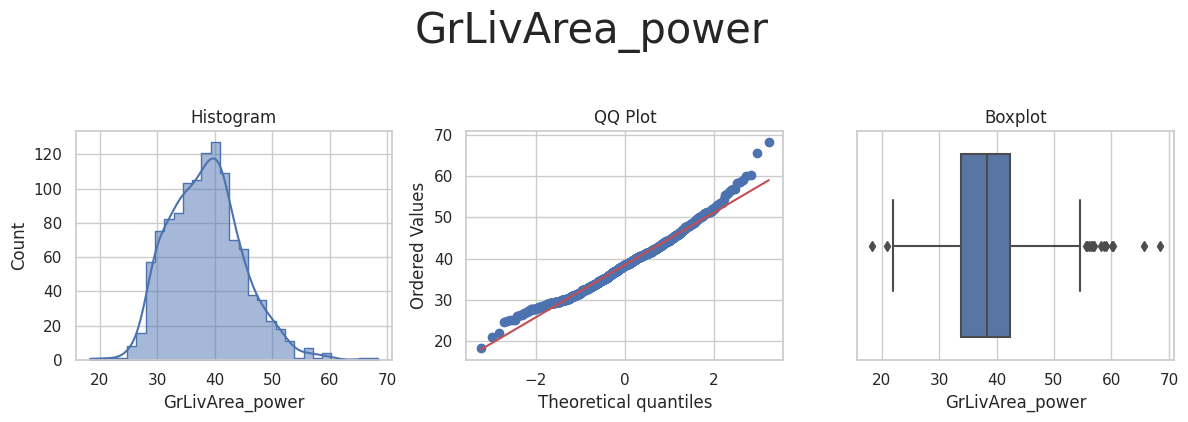

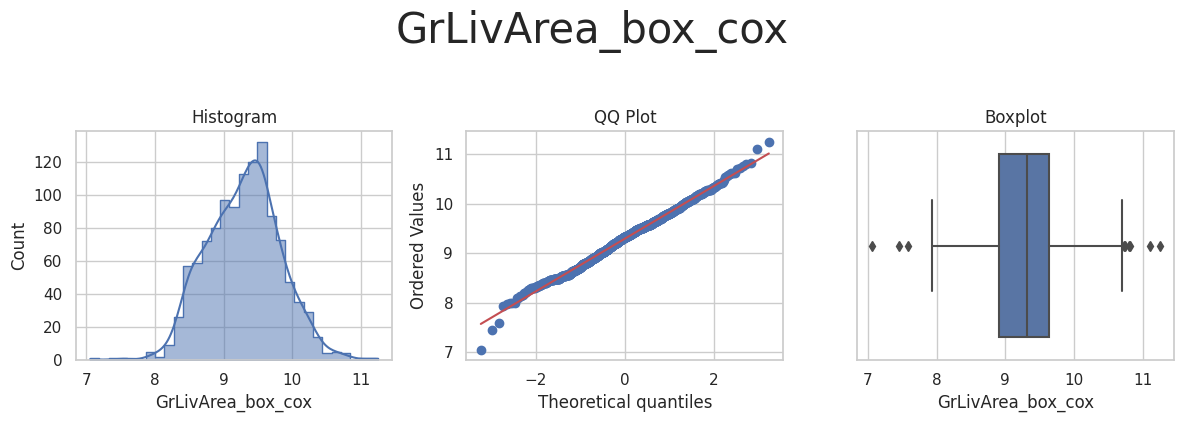

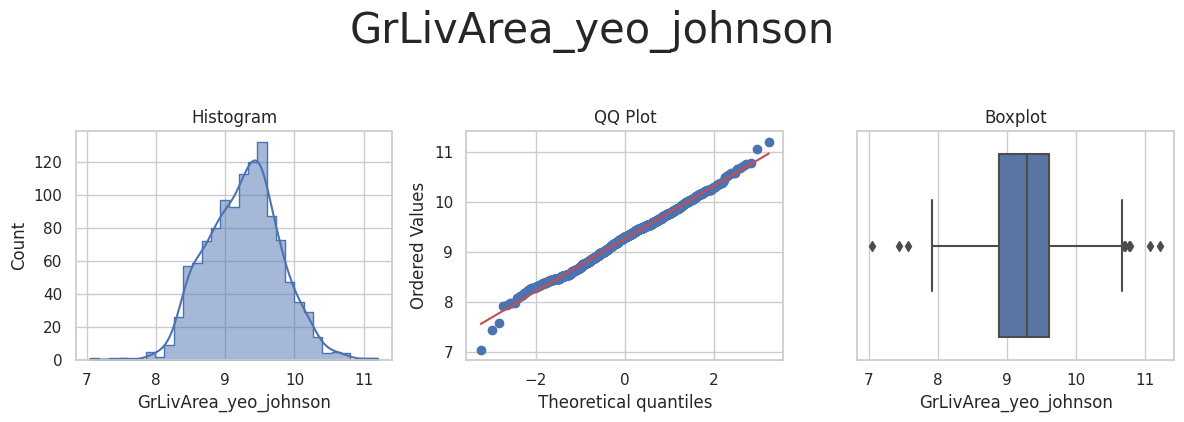



* Variable Analyzed: KitchenQual
* Applied transformation: ['KitchenQual_power', 'KitchenQual_yeo_johnson'] 



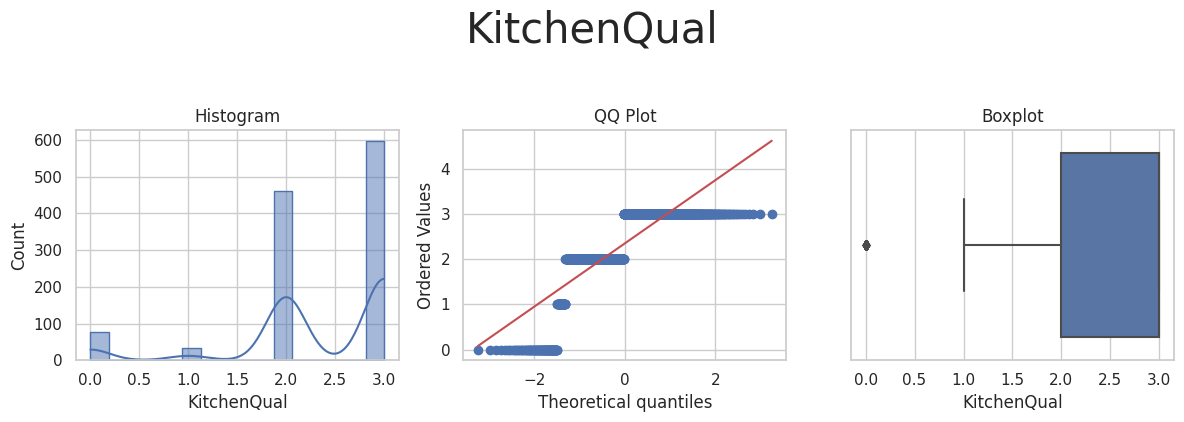

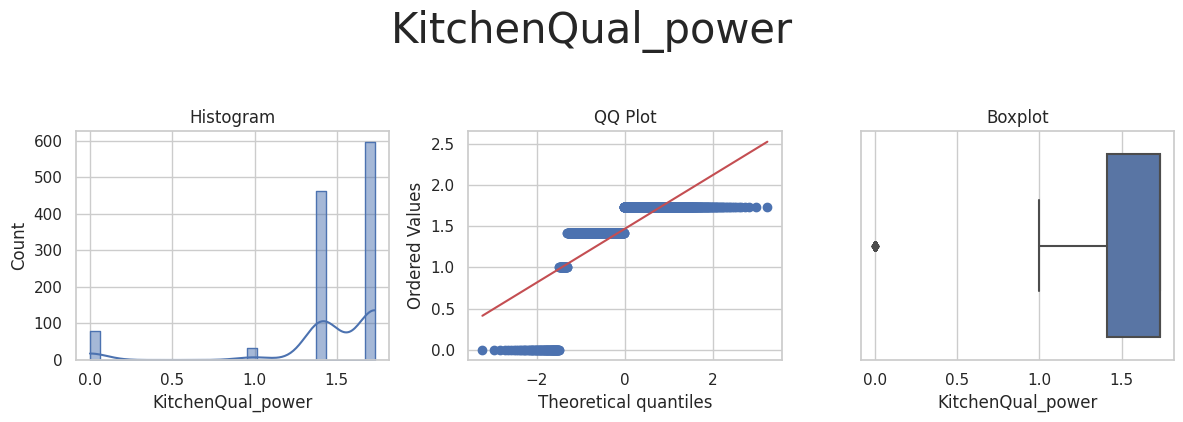

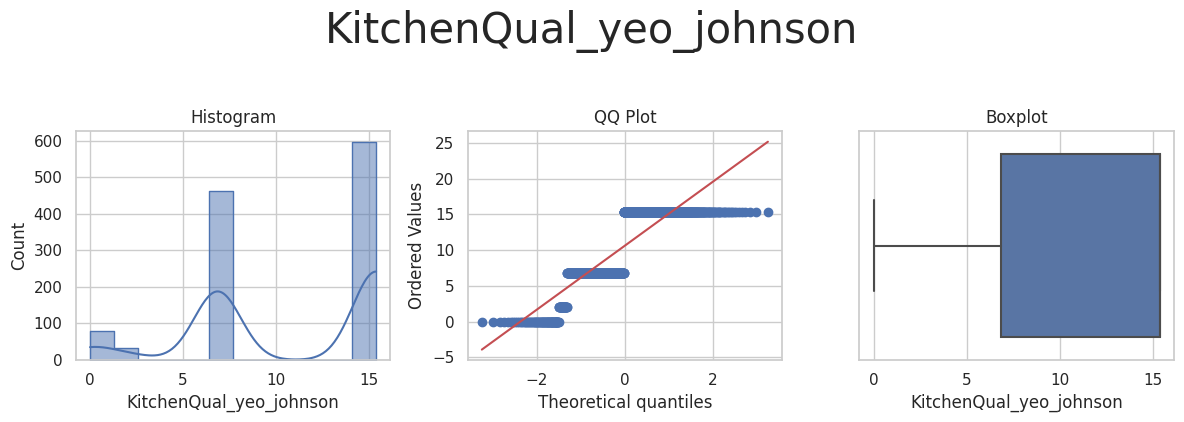



* Variable Analyzed: LotArea
* Applied transformation: ['LotArea_log_e', 'LotArea_log_10', 'LotArea_reciprocal', 'LotArea_power', 'LotArea_box_cox', 'LotArea_yeo_johnson'] 



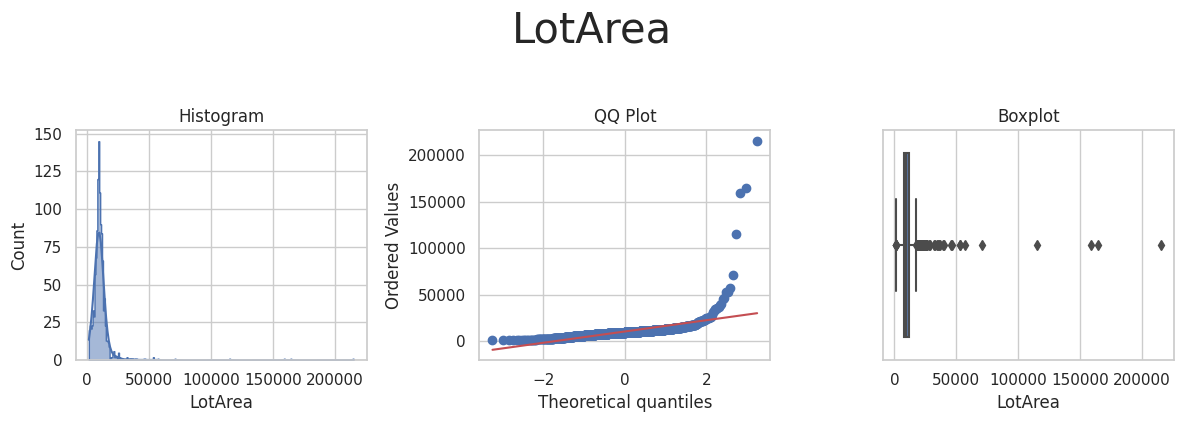

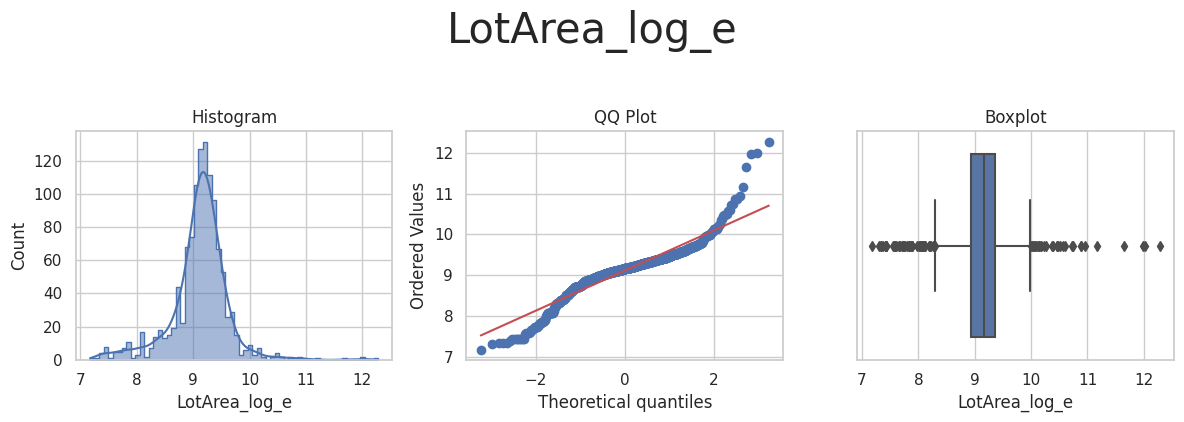

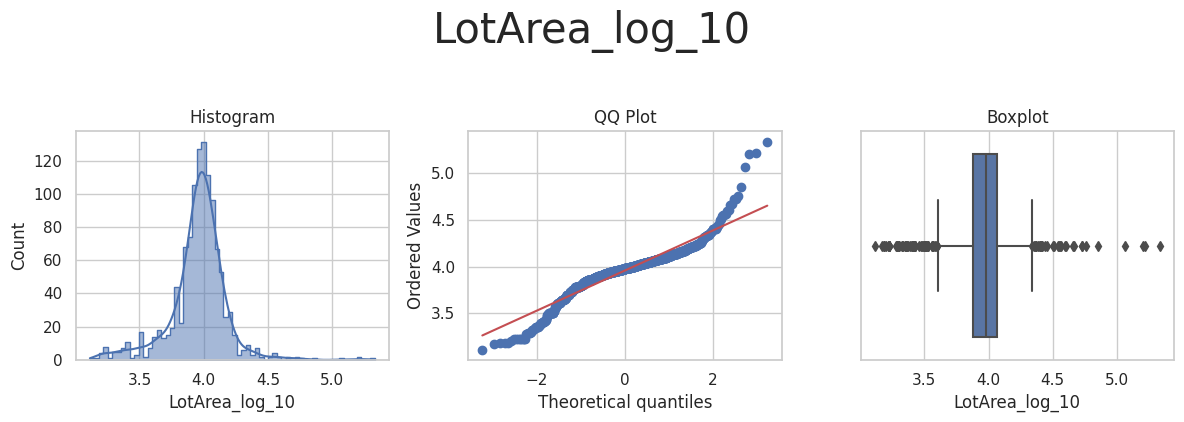

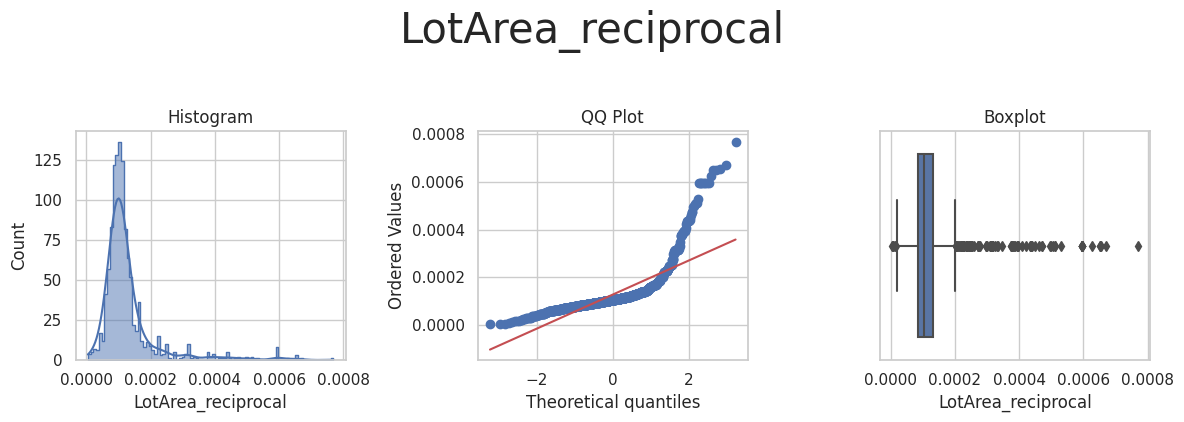

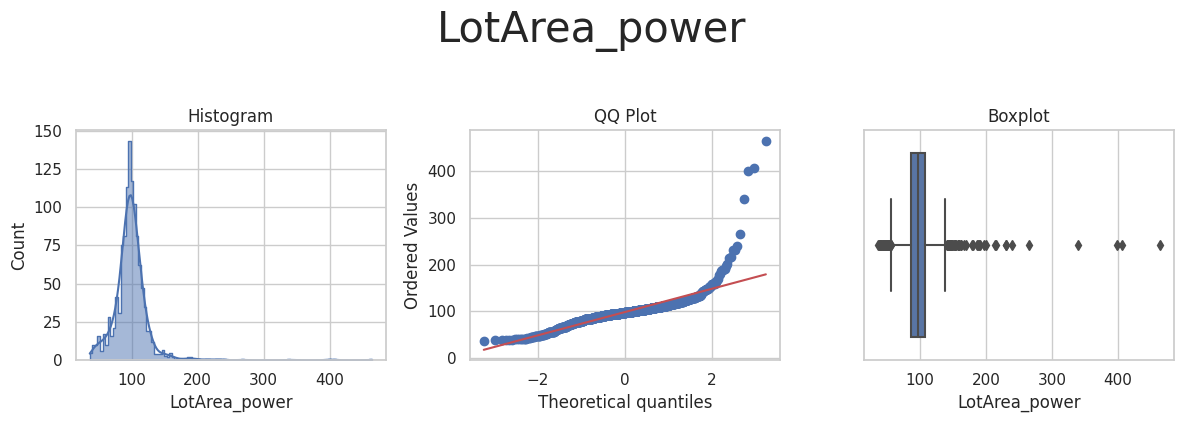

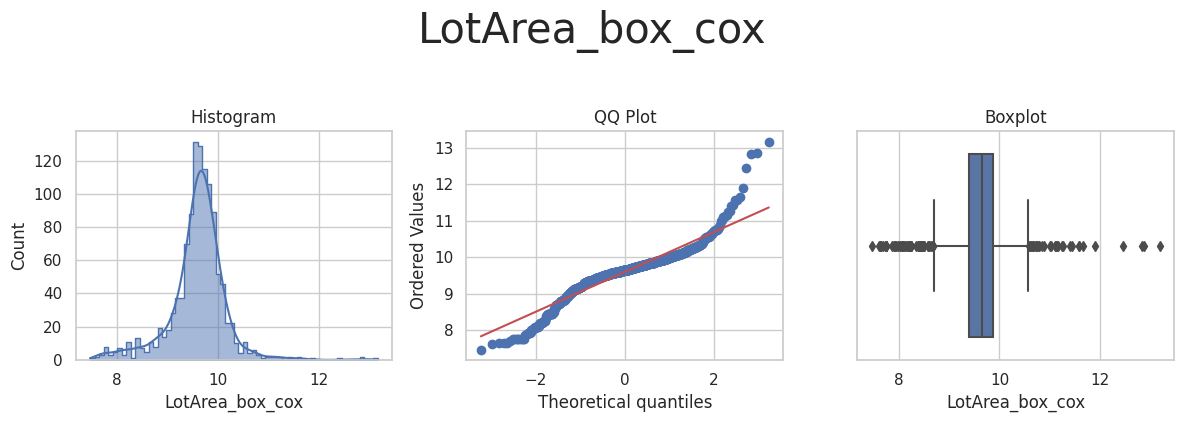

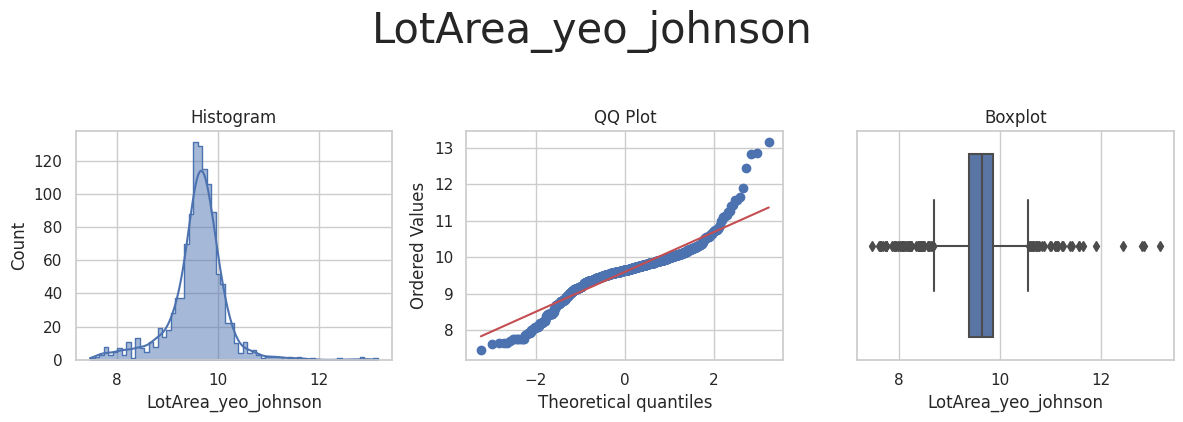



* Variable Analyzed: LotFrontage
* Applied transformation: ['LotFrontage_log_e', 'LotFrontage_log_10', 'LotFrontage_reciprocal', 'LotFrontage_power', 'LotFrontage_box_cox', 'LotFrontage_yeo_johnson'] 



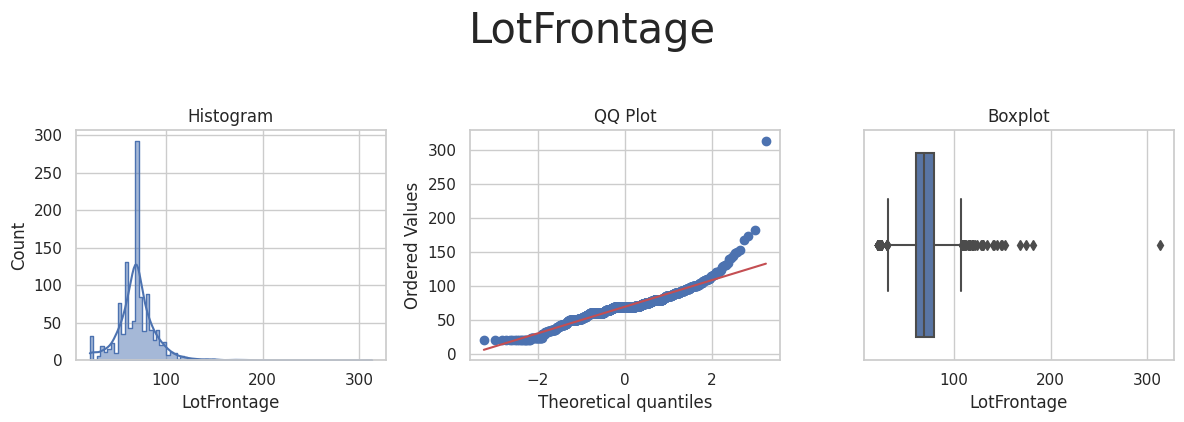

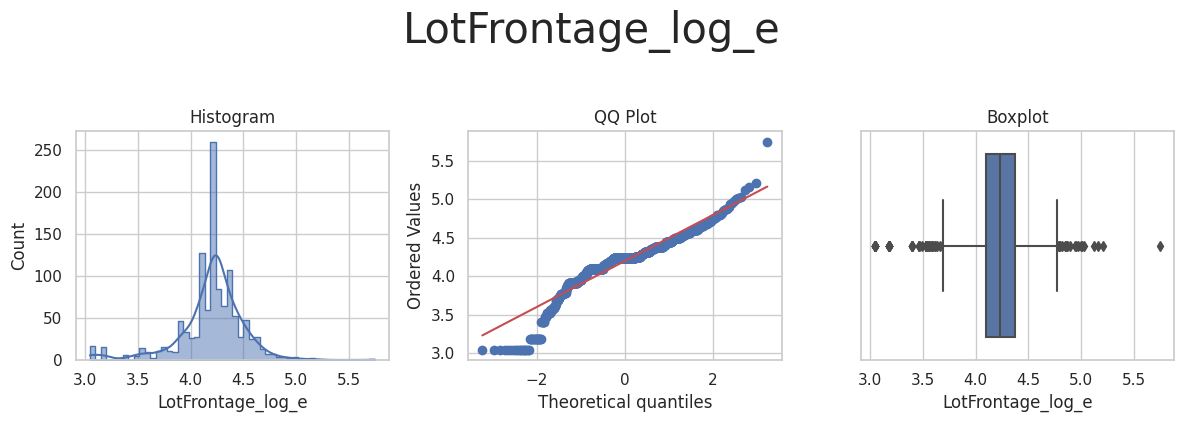

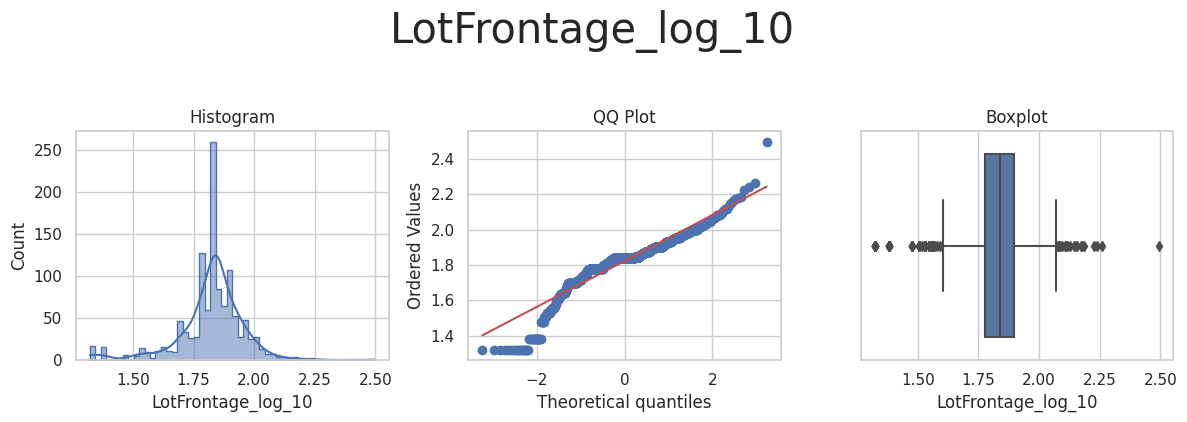

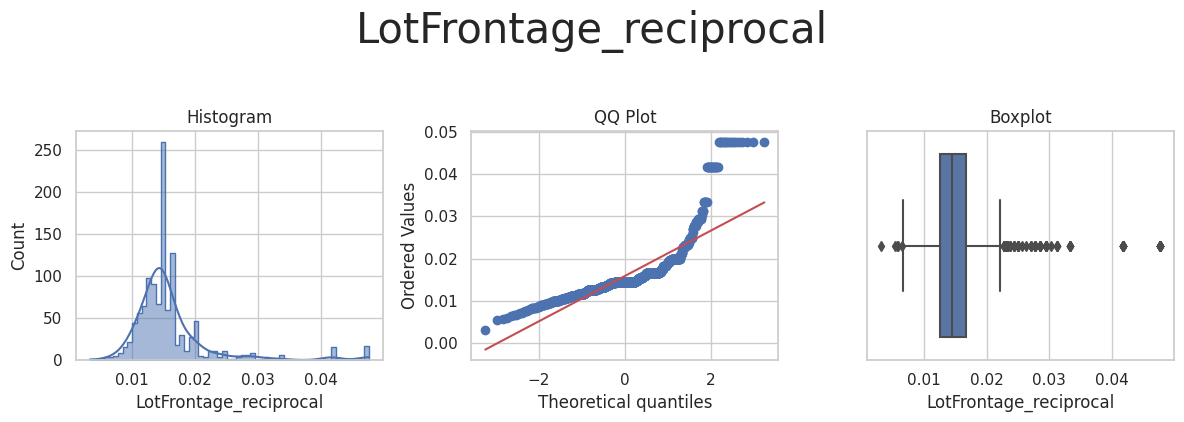

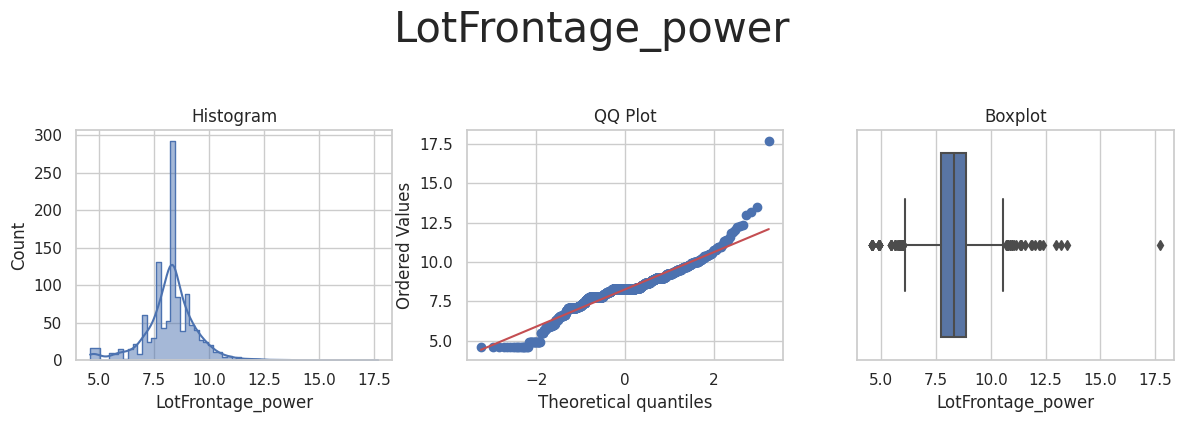

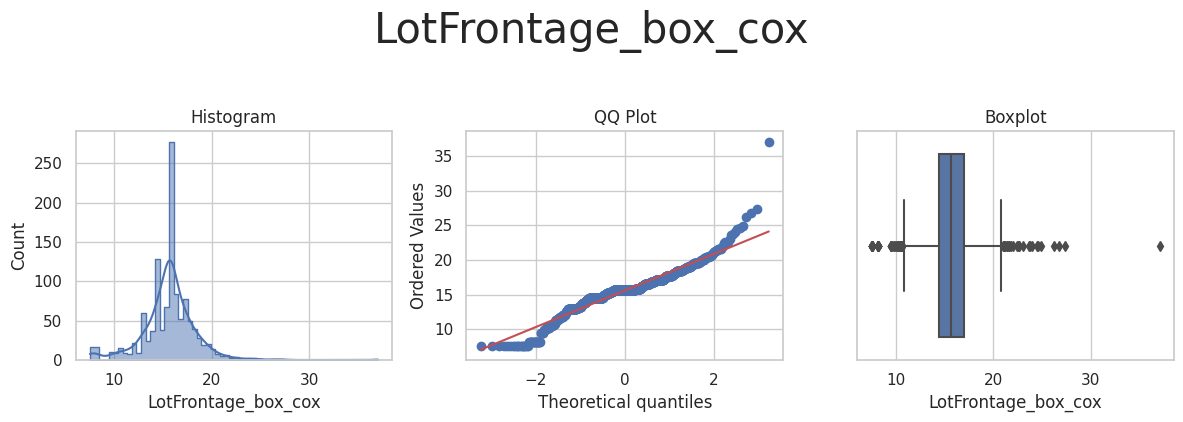

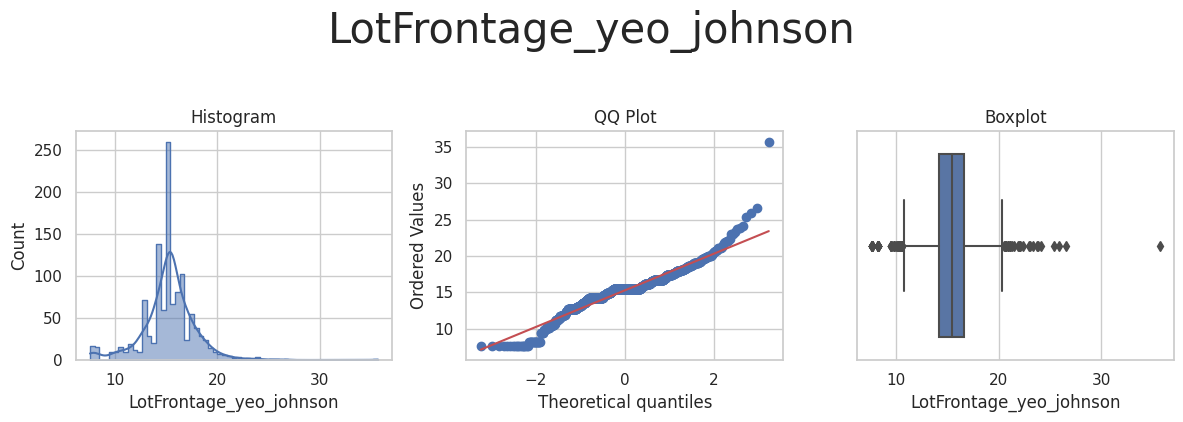



* Variable Analyzed: MasVnrArea
* Applied transformation: ['MasVnrArea_power', 'MasVnrArea_yeo_johnson'] 



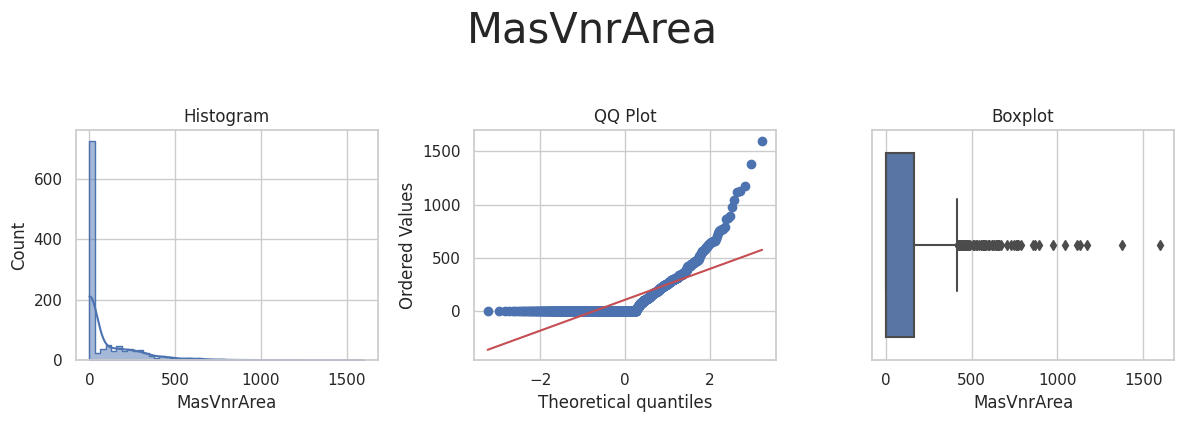

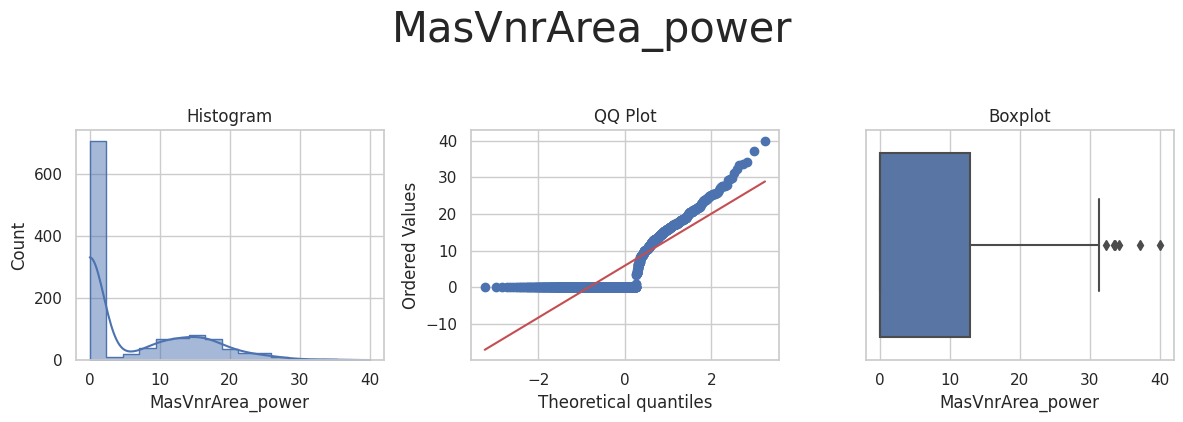

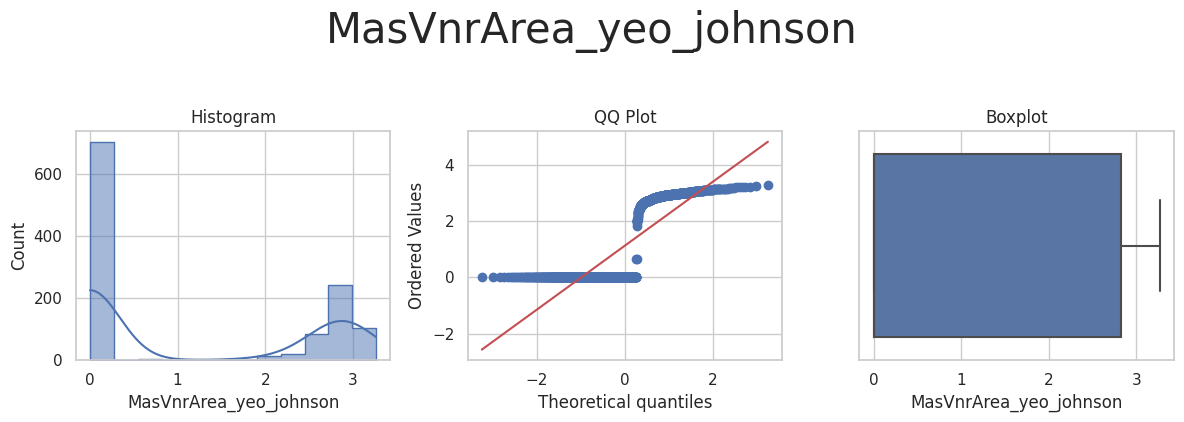



* Variable Analyzed: OpenPorchSF
* Applied transformation: ['OpenPorchSF_power', 'OpenPorchSF_yeo_johnson'] 



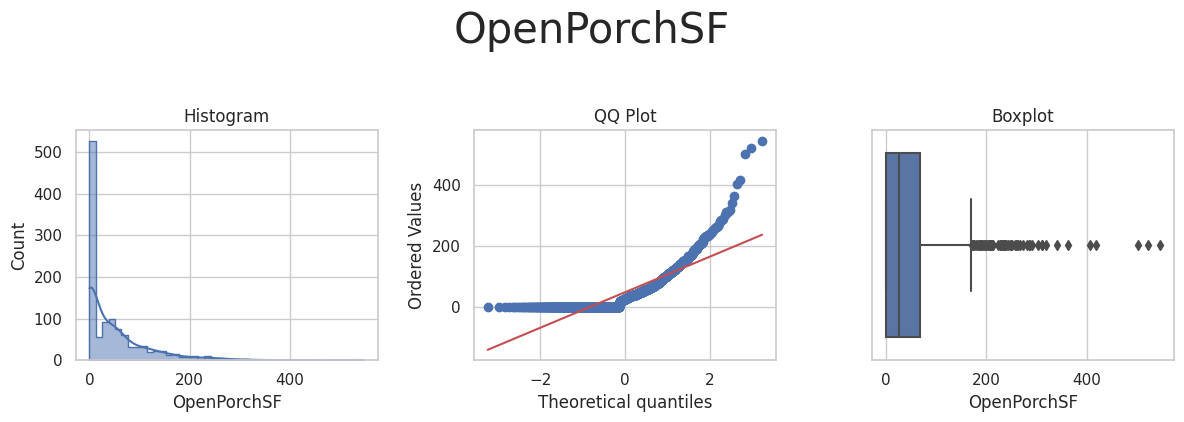

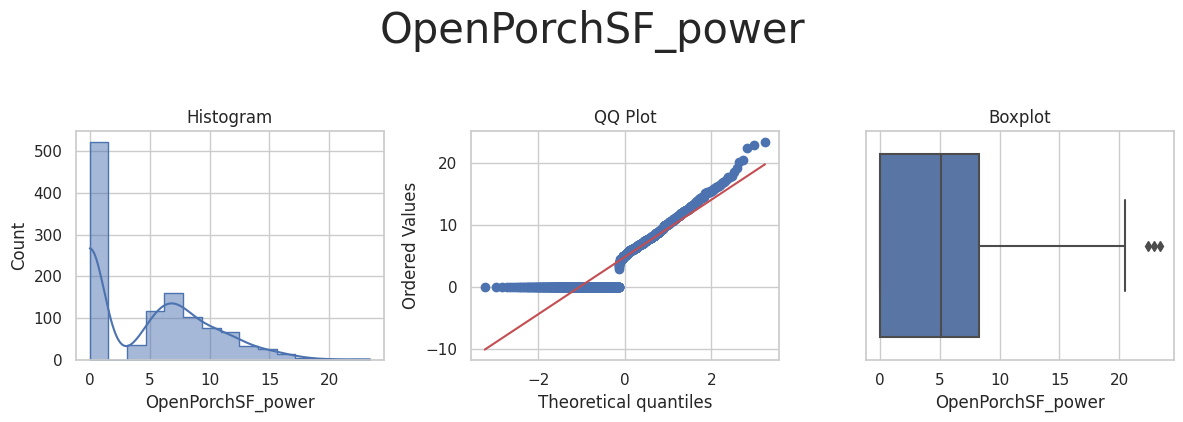

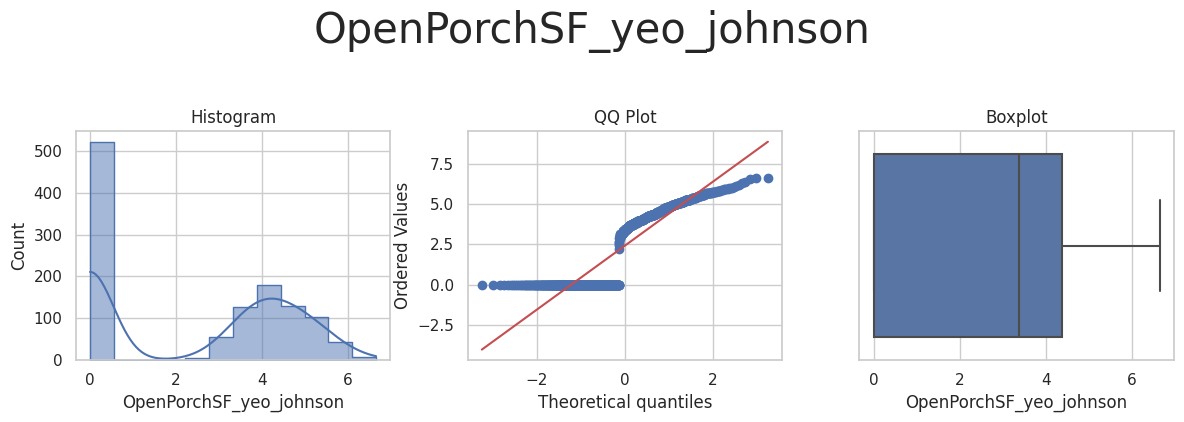



* Variable Analyzed: OverallCond
* Applied transformation: ['OverallCond_log_e', 'OverallCond_log_10', 'OverallCond_reciprocal', 'OverallCond_power', 'OverallCond_box_cox', 'OverallCond_yeo_johnson'] 



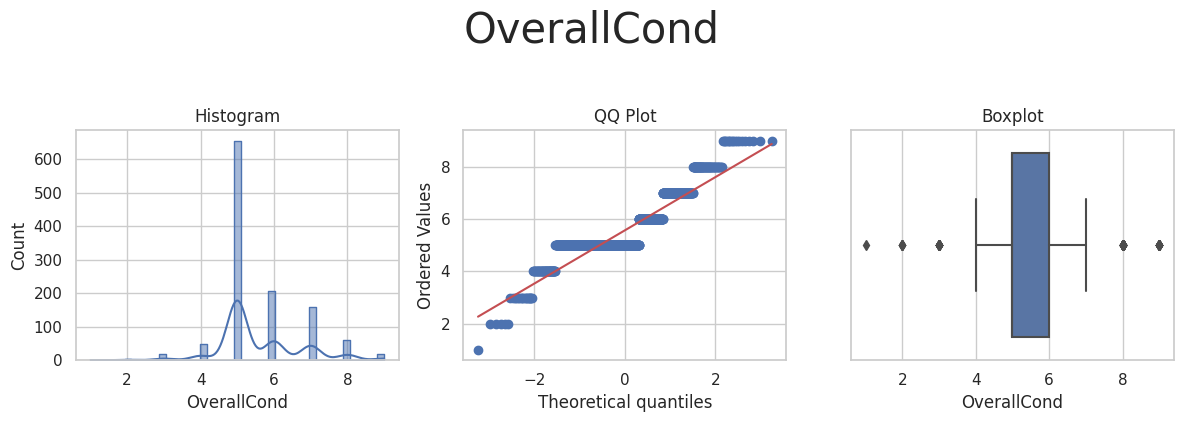

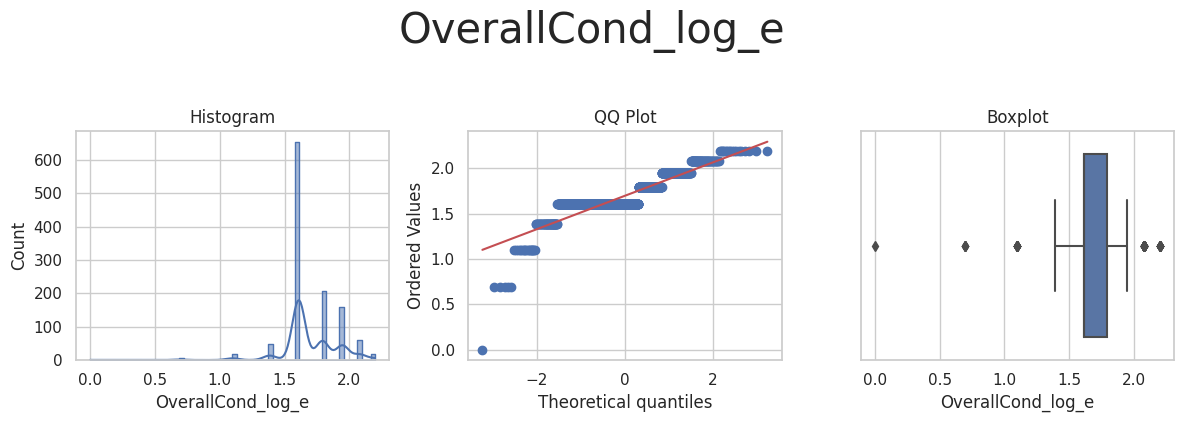

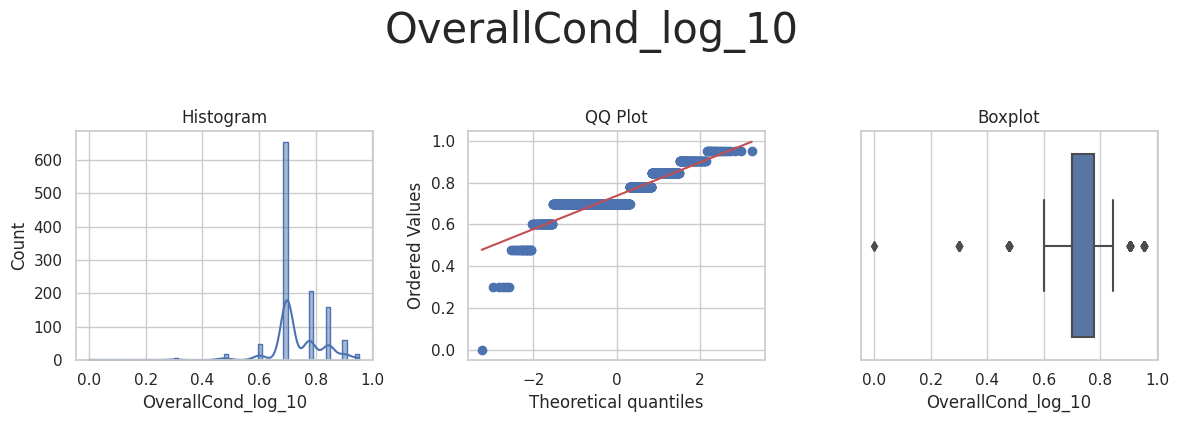

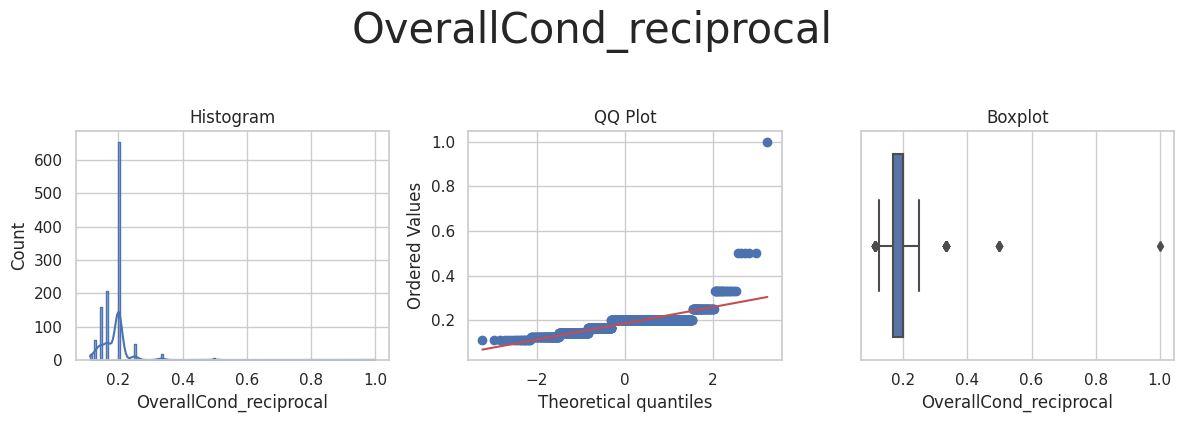

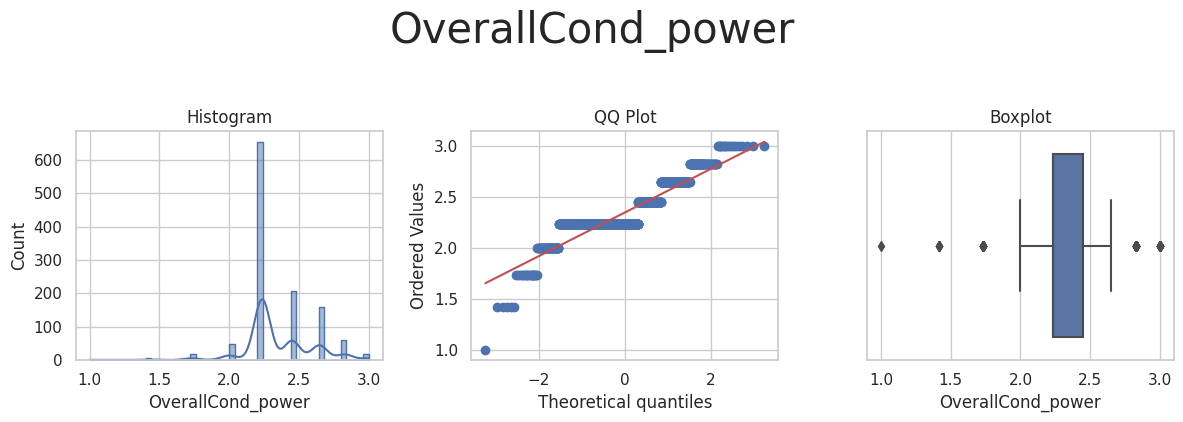

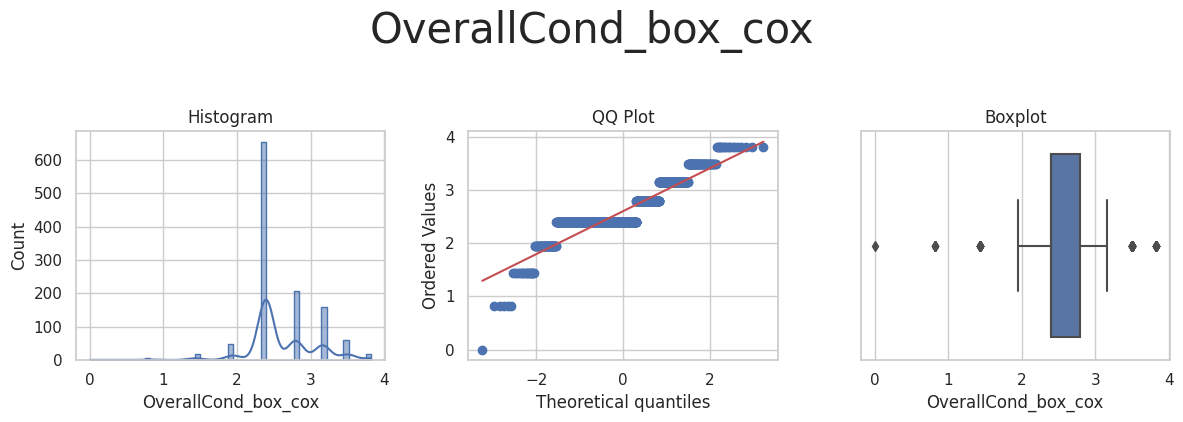

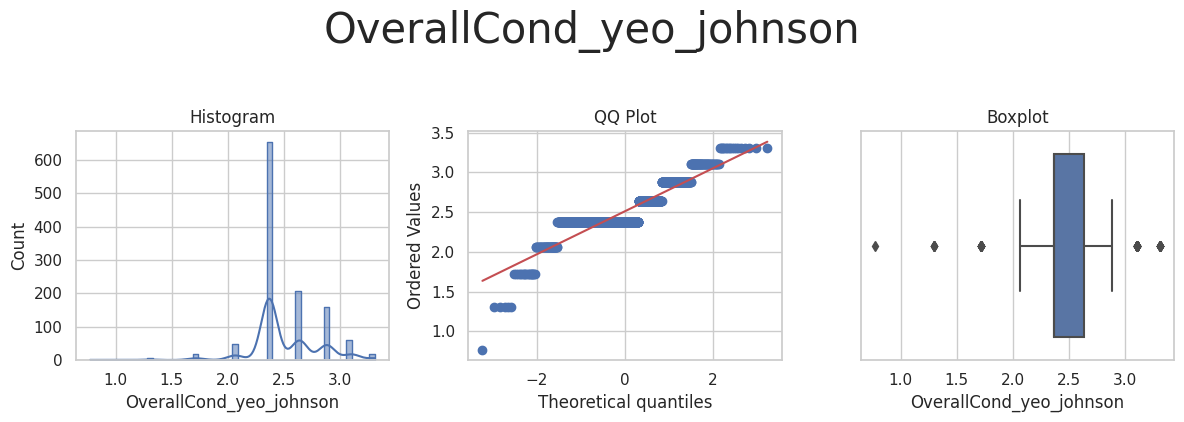



* Variable Analyzed: OverallQual
* Applied transformation: ['OverallQual_log_e', 'OverallQual_log_10', 'OverallQual_reciprocal', 'OverallQual_power', 'OverallQual_box_cox', 'OverallQual_yeo_johnson'] 



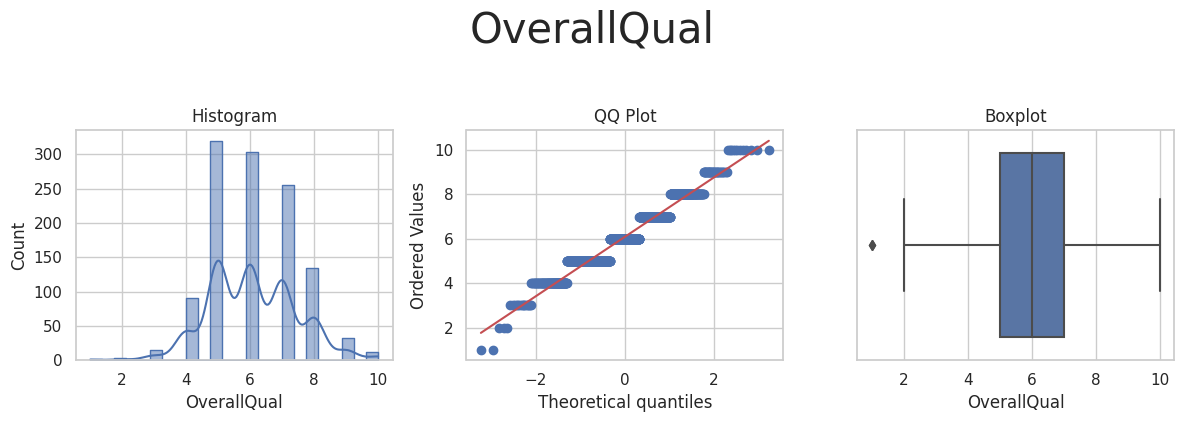

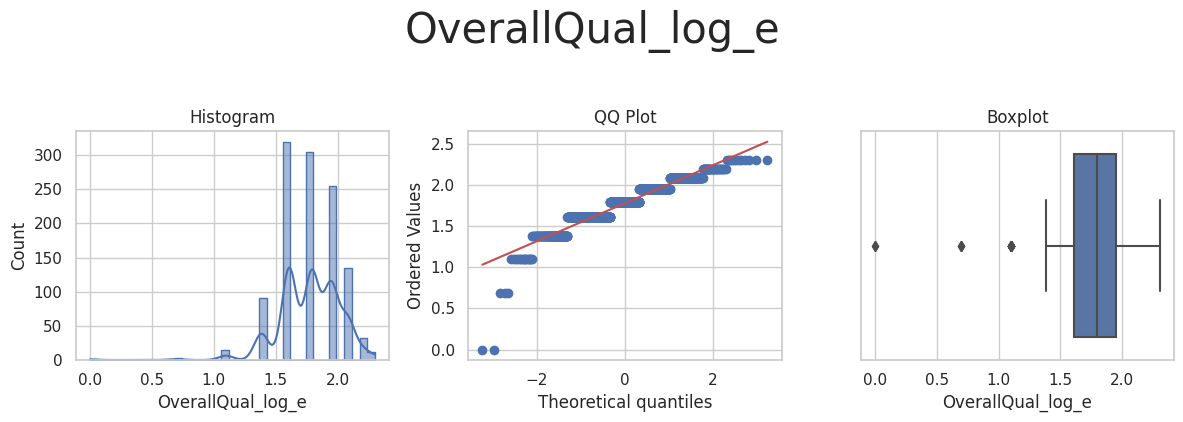

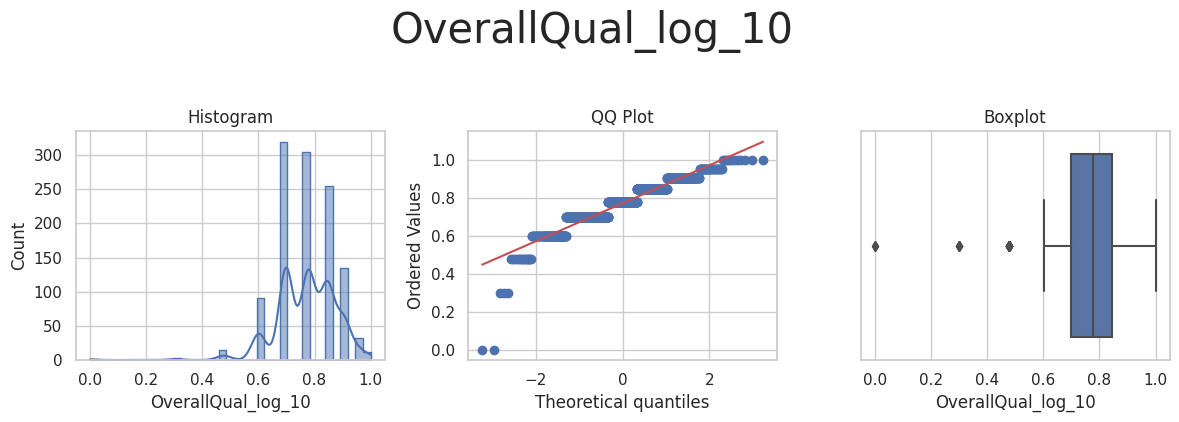

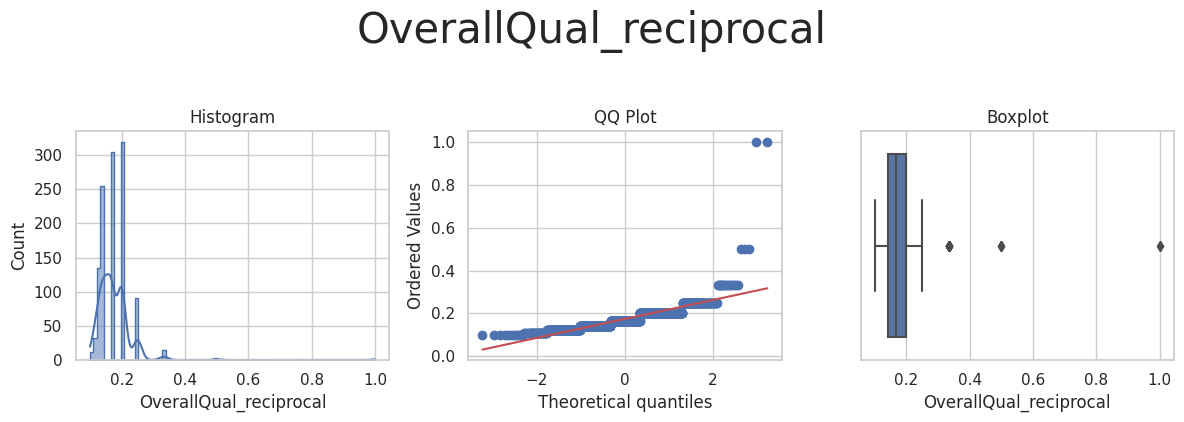

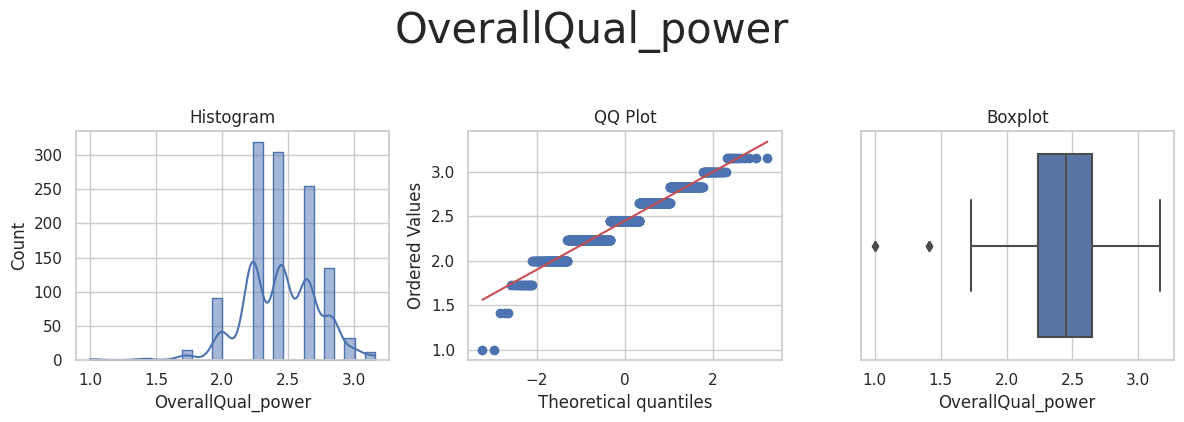

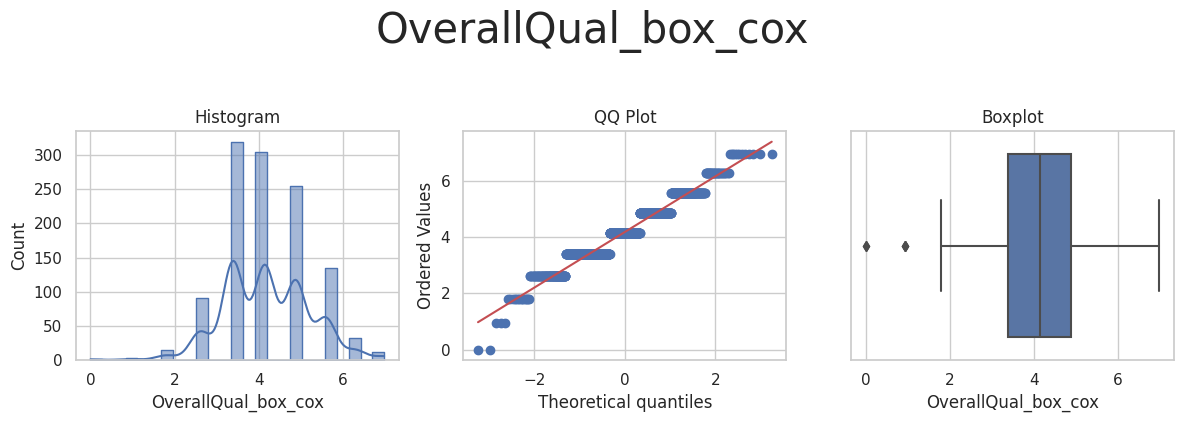

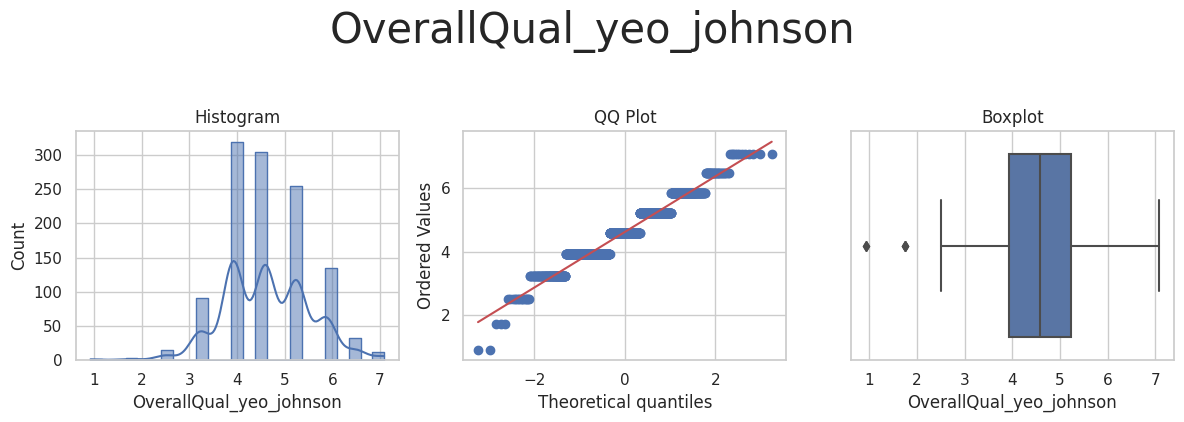



* Variable Analyzed: TotalBsmtSF
* Applied transformation: ['TotalBsmtSF_power', 'TotalBsmtSF_yeo_johnson'] 



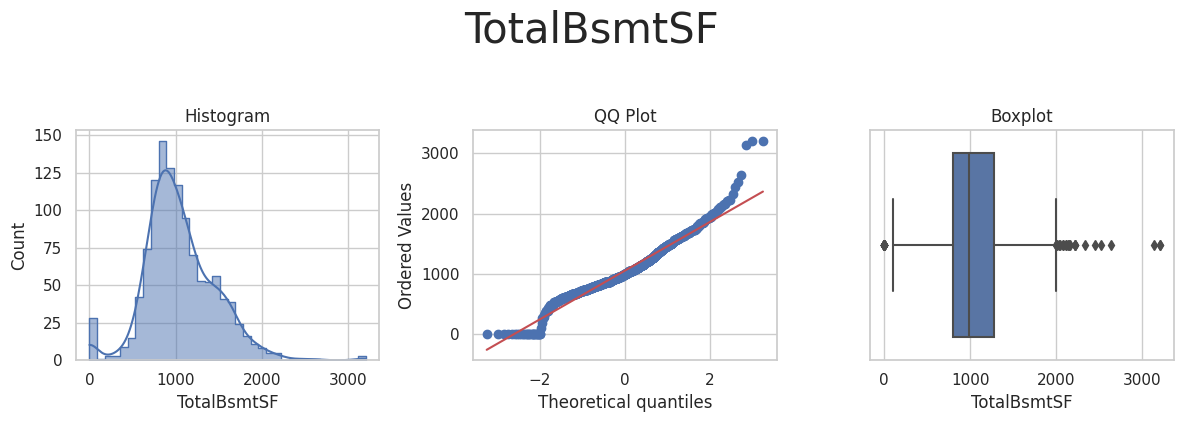

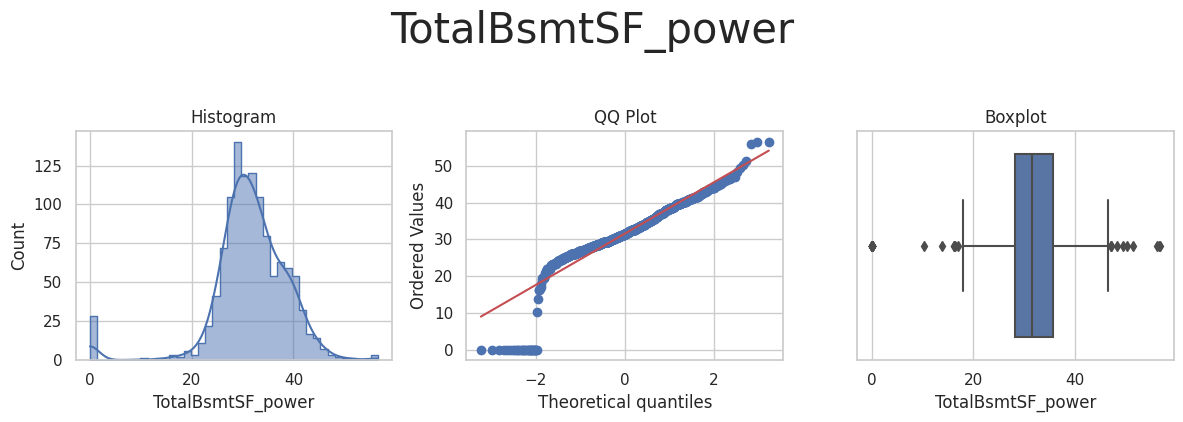

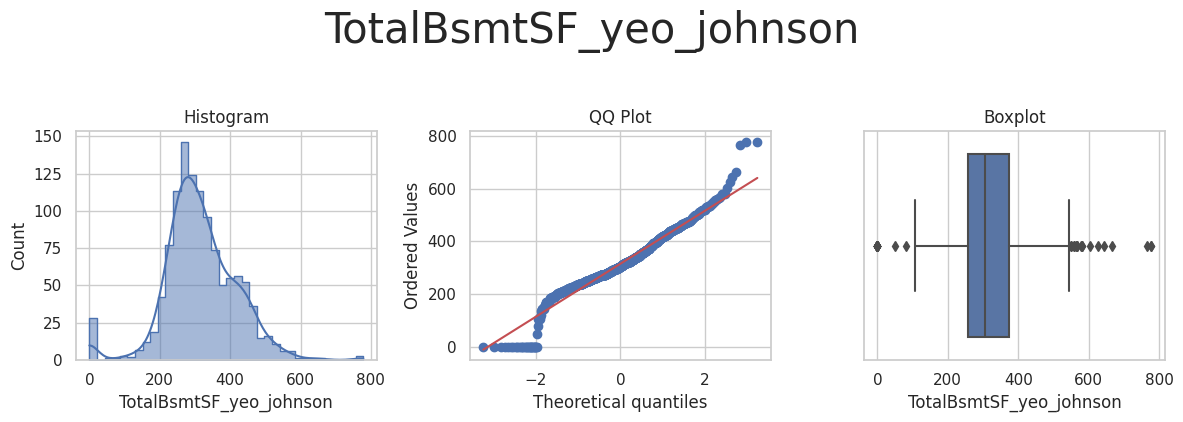



* Variable Analyzed: YearBuilt
* Applied transformation: ['YearBuilt_log_e', 'YearBuilt_log_10', 'YearBuilt_reciprocal', 'YearBuilt_power', 'YearBuilt_box_cox', 'YearBuilt_yeo_johnson'] 



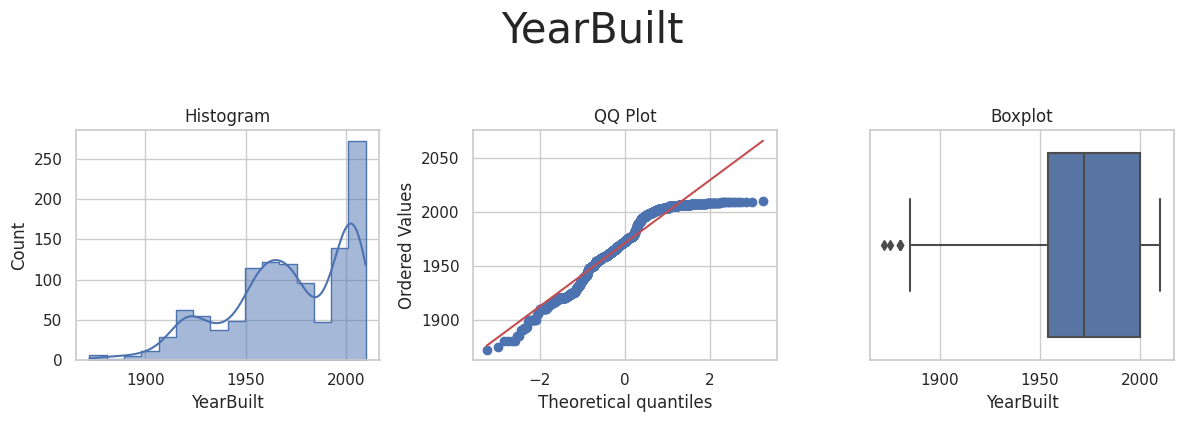

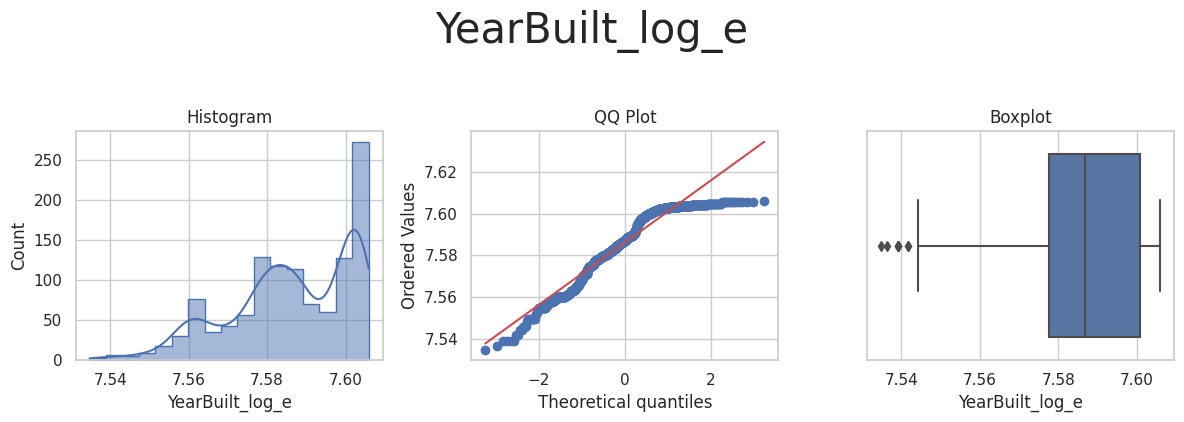

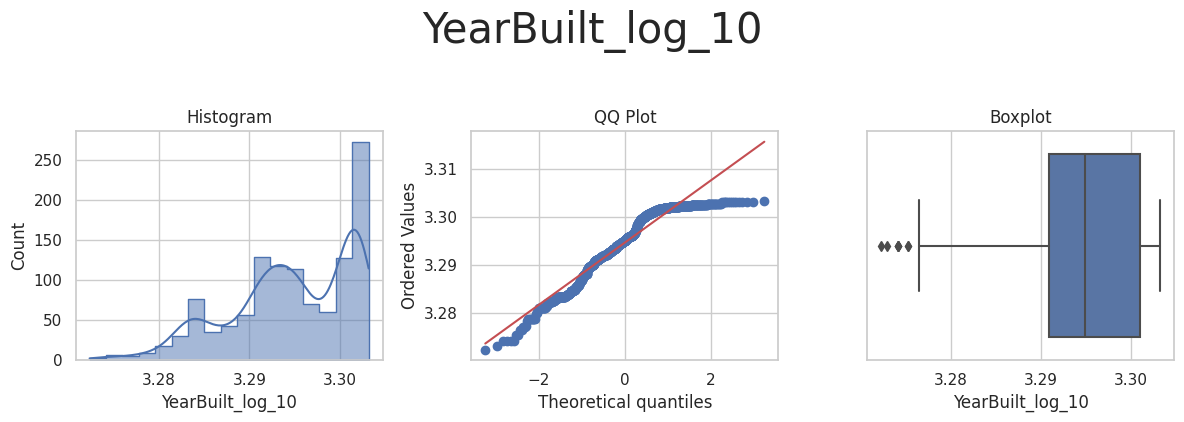

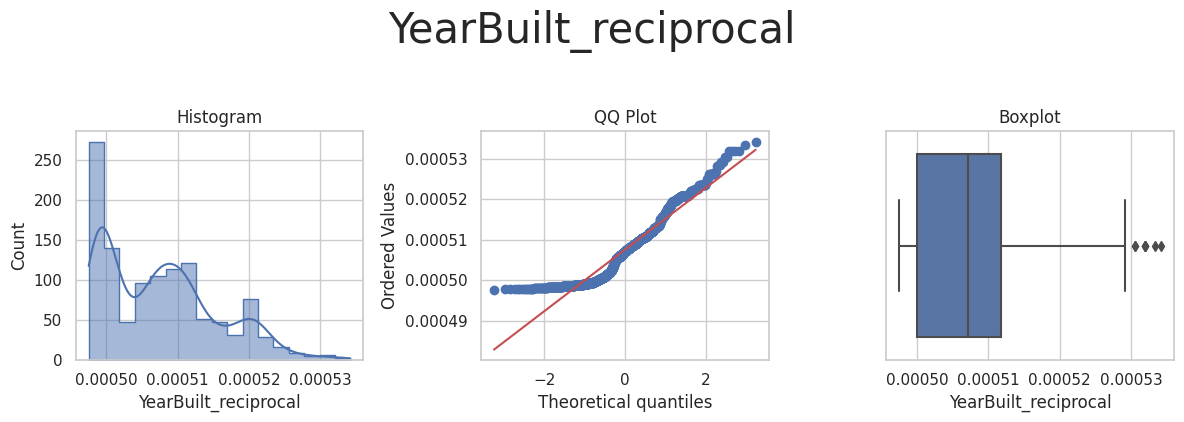

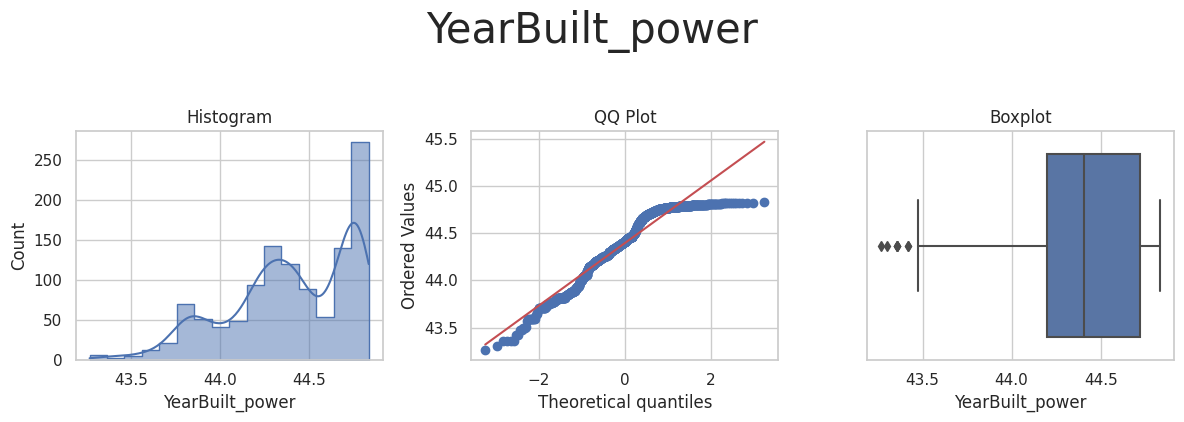

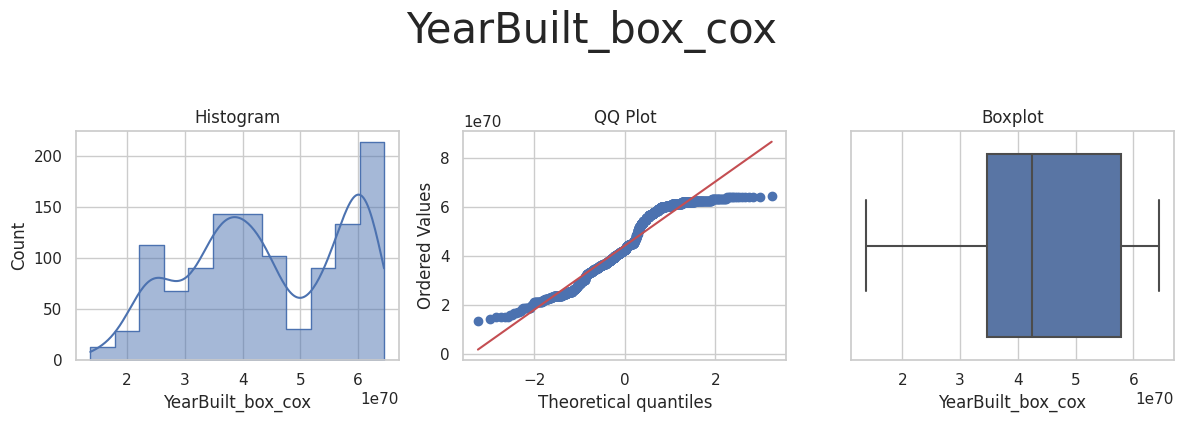

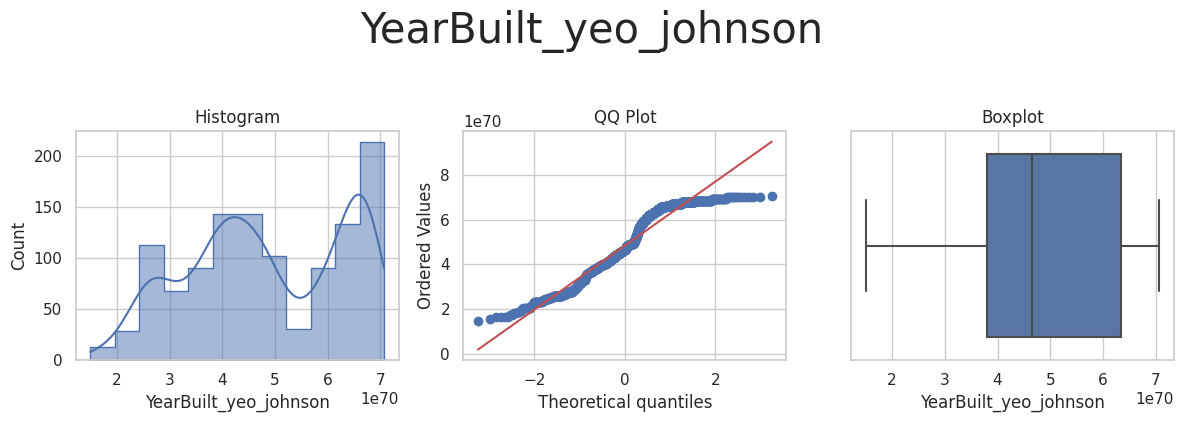



* Variable Analyzed: YearRemodAdd
* Applied transformation: ['YearRemodAdd_log_e', 'YearRemodAdd_log_10', 'YearRemodAdd_reciprocal', 'YearRemodAdd_power', 'YearRemodAdd_box_cox', 'YearRemodAdd_yeo_johnson'] 



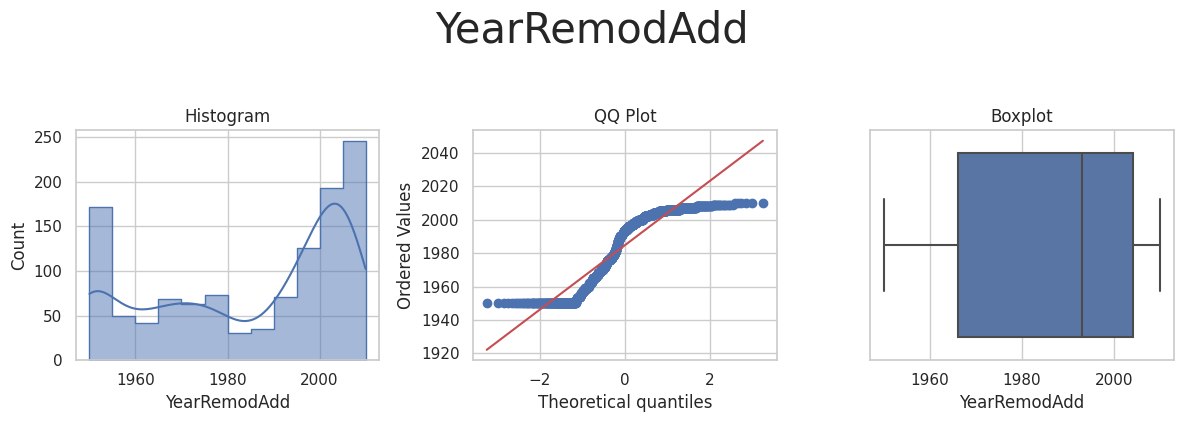

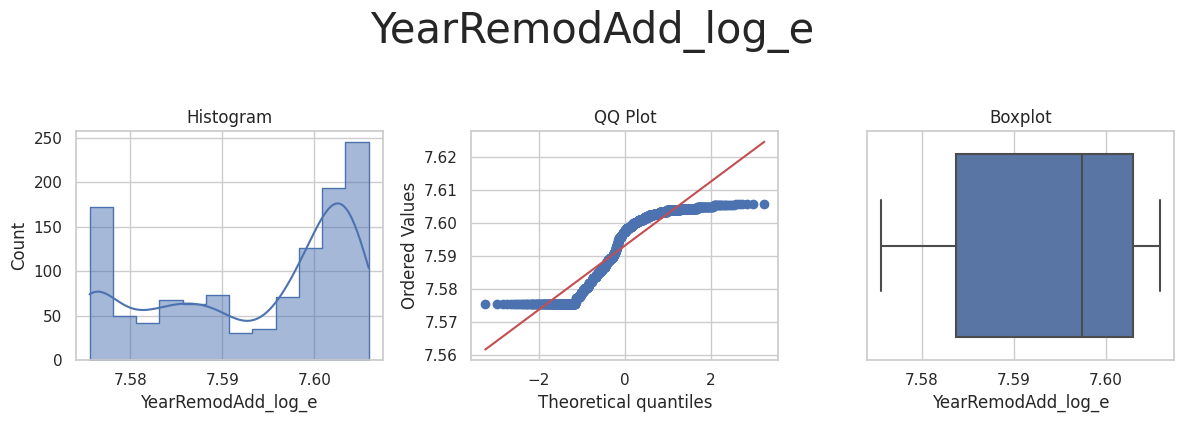

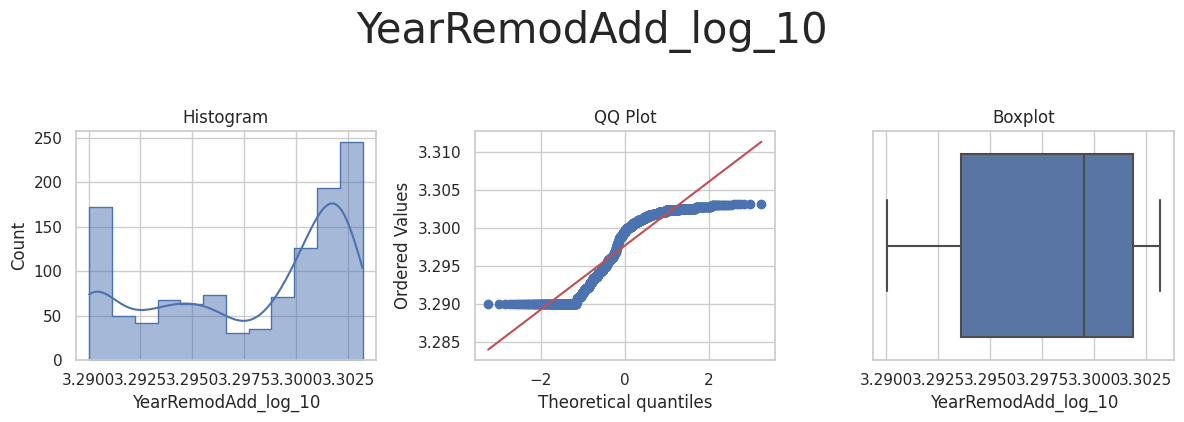

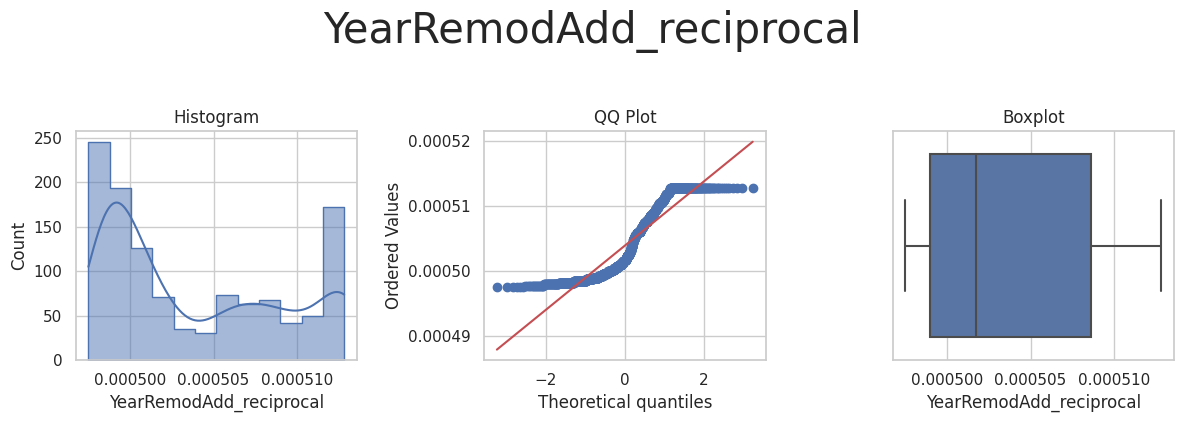

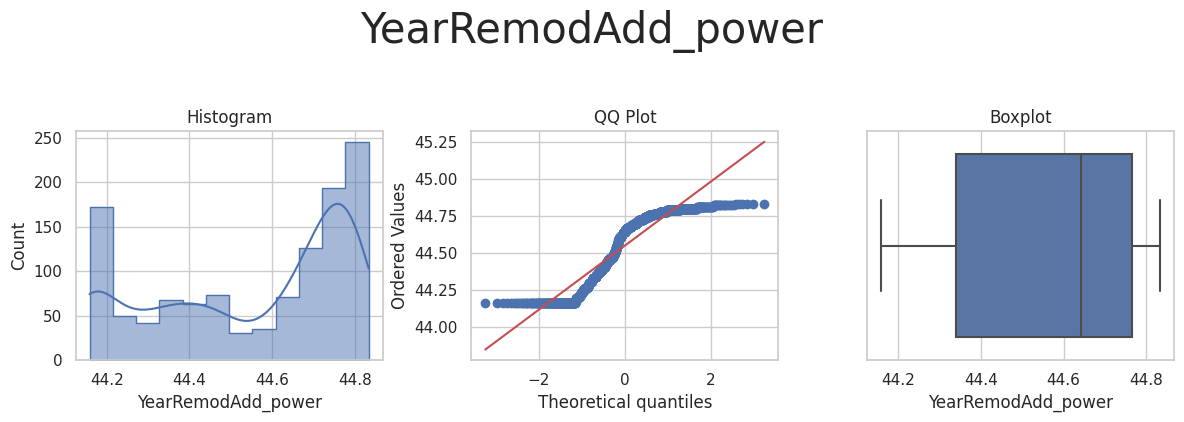

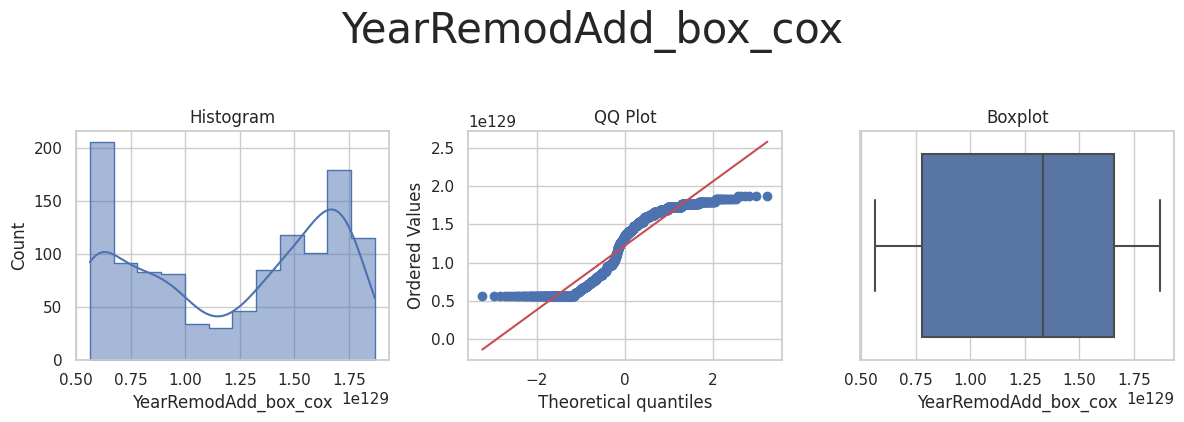

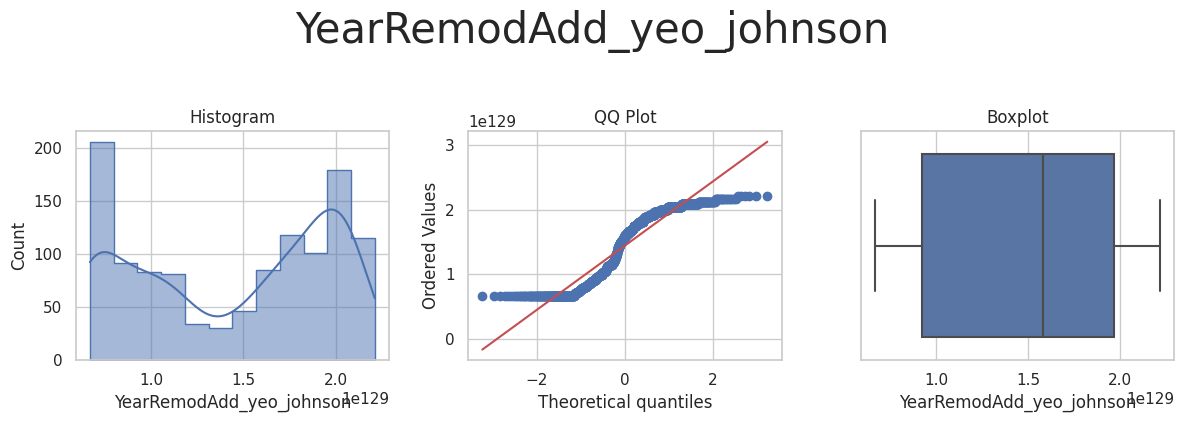



* Variable Analyzed: SalePrice
* Applied transformation: ['SalePrice_log_e', 'SalePrice_log_10', 'SalePrice_reciprocal', 'SalePrice_power', 'SalePrice_box_cox', 'SalePrice_yeo_johnson'] 



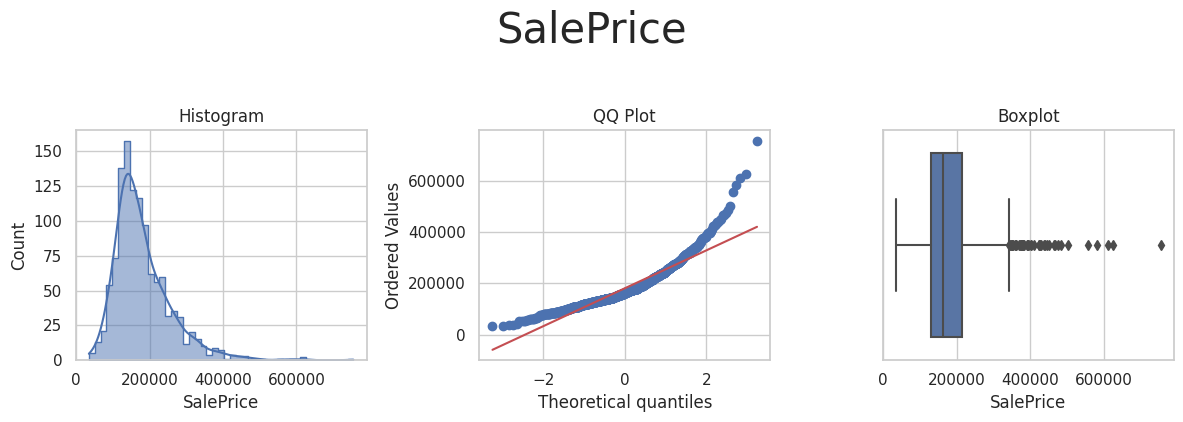

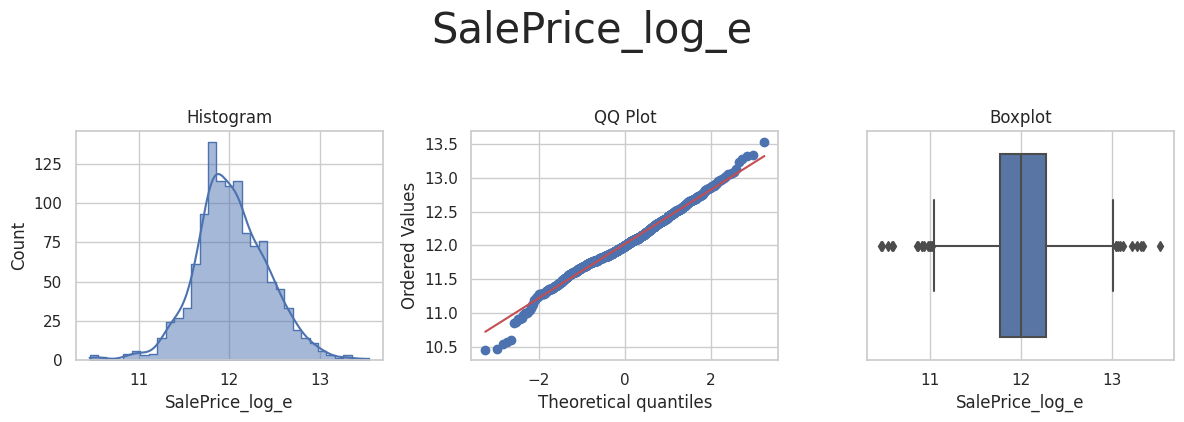

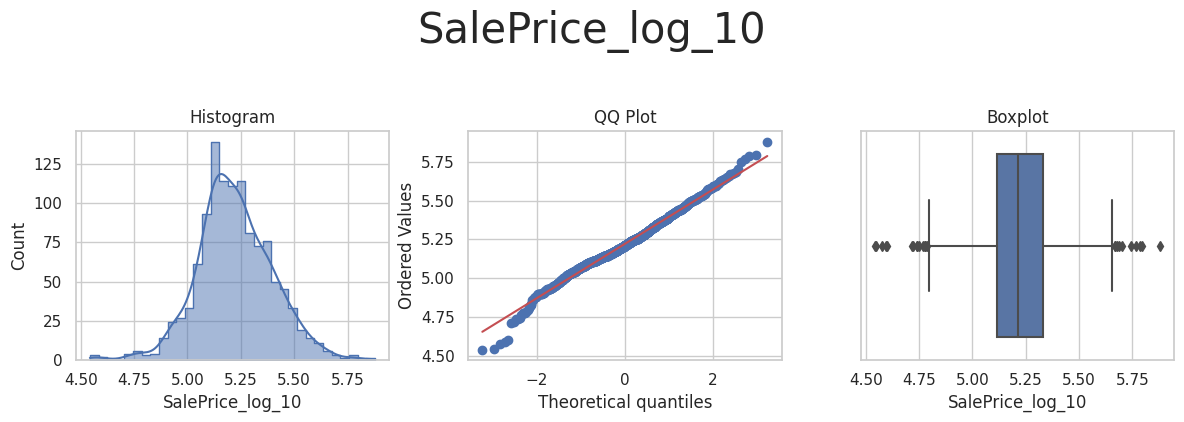

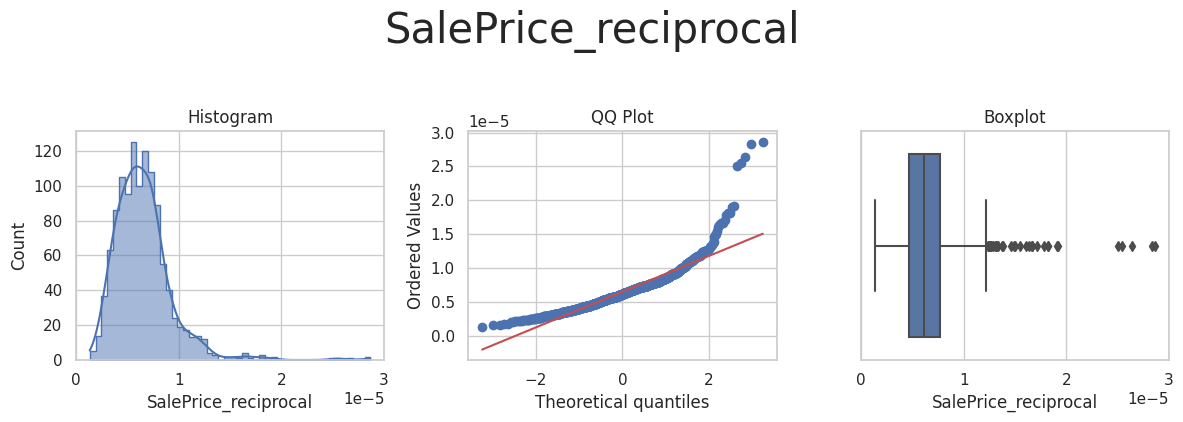

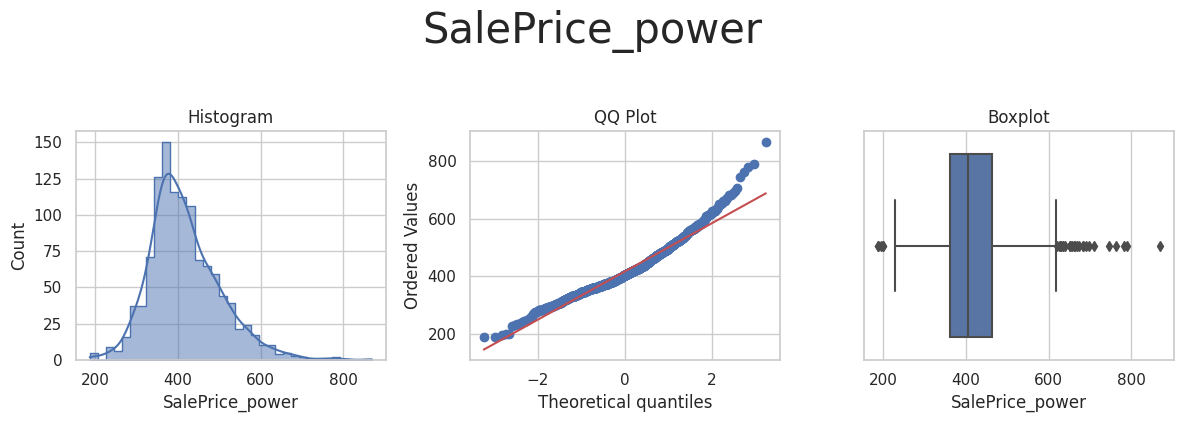

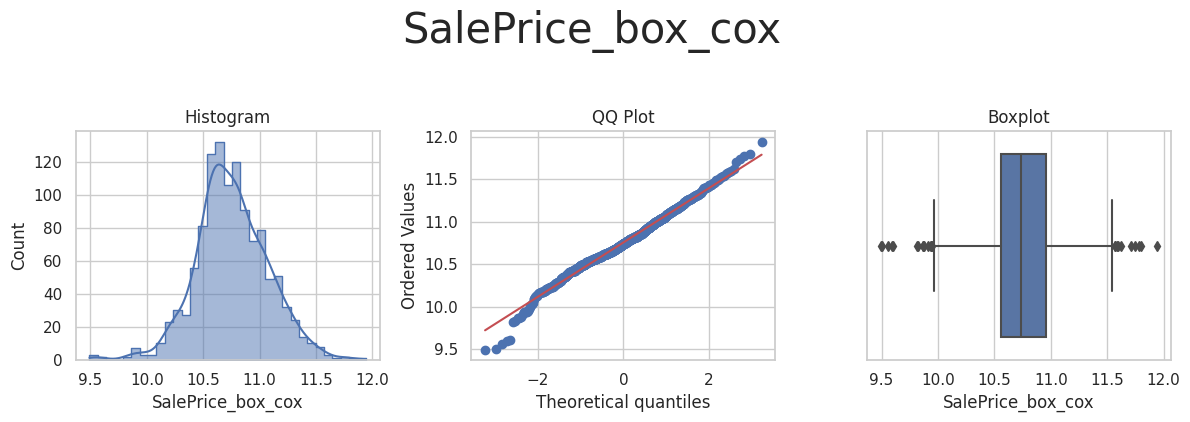

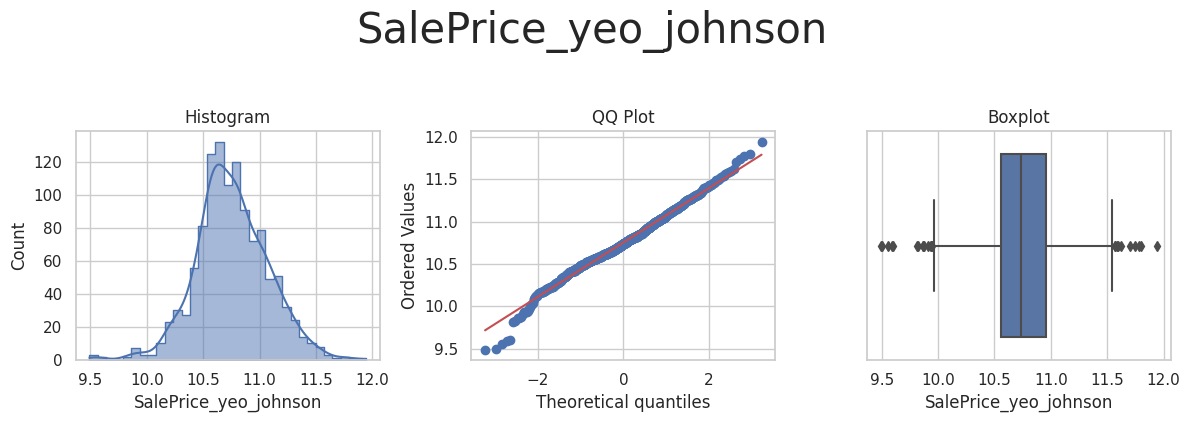

In [12]:
df_numerical_engineered = FeatureEngineeringAnalysis(df=df_numerical, analysis_type='numerical')

---

## Analysis of plots

* Variables Analyzed: `1stFlrSF`, `GrLivArea`, `LotArea`, `SalePrice`
* Applied transformation:
  * `Log e`, `Log 10`, `Reciprocal`, `Power`, `Box Cox`, `Yeo Johnson` 
* With exception of `Reciprocal` and `Power`, the applied transformations show an improvement in terms of distribution shape and QQ plot. The transformed options show characteristics of normal distribution. 
* Conclusion:
  * `Log e`, `Log 10`, `Box Cox` and `Yeo Johnson` may be considered for numerical transformation of `1stFlrSF`, `GrLivArea`, `LotArea` and `SalePrice`.

* Variables Analyzed: `2ndFlrSF`, `BedroomAbvGr`, `BsmtFinSF1`, `BsmtUnfSF`, `GarageArea`, `GarageYrBlt`, `TotalBsmtSF`
* Applied transformation:
  * `Power`, `Yeo Johnson`
* Only 2 transformations applied were `Power` and `Yeo Johnson`.
* Neither of the plots show an improvement in terms of distribution shape and QQ plot, since the transformed options
don't show characteristics of normal distribution.
* Conclusion:
  * These variables will not be considered for numerical transformation.

* Variables Analyzed: `MasVnrArea`
* Applied transformation:
  * `Power`, `Yeo Johnson`
* Only 2 transformations were applied, `Power` and `Yeo Johnson`.
* The plots for `Power` show an improvement in terms of distribution shape and QQ plot, and show characteristics of normal distribution.
* However, `Yeo Johnson` does not show any improvement.
* Conclusion:
  * `Power` may be considered for numerical transformation of `MasVnrArea`.

* Variables Analyzed: `LotFrontage`, `OverallCond`, `OverallQual`
* Applied transformation:
  * `Log e`, `Log 10`, `Reciprocal`, `Power`, `Box Cox`, `Yeo Johnson`
* `Power`, `Box Cox` and `Yeo Johnson` transformations show similar results on the distribution shape and QQ plot to that of the plot before transformation.
* `Log e`, `Log 10` and `Reciprocal` do not show improvement. 
* Conclusion:
  * This variable will not be considered for numerical transformation.

* Variable Analyzed: `OpenPorchSF`
* Applied transformation:
  * `Power`, `Yeo Johnson`
* Only 2 transformations were applied, `Power` and `Yeo Johnson`.
* The plots for `Yeo Johnson` show improvement in terms of distribution shape and QQ plot, and show characteristics of normal distribution.
* However, `Power` does not show any improvement.
* Conclusion:
  * `Yeo Johnson` may be considered for numerical transformation of `OpenPorchSF`.

* Variable Analyzed: `YearBuilt`, `YearRemodAdd`
* Applied transformation:
  * `Log e`, `Log 10`, `Reciprocal`, `Power`, `Box Cox`, `Yeo Johnson`
* Transformations on these variables offered no improvement.
* Conclusion:
  * These variables will not be considered for numerical transformation.

---

4. Apply the transformation to the Train and Test datasets.

In [13]:
from sklearn.pipeline import Pipeline
pipeline = Pipeline([
    ("NumericLogTransform",vt.LogTransformer(variables=['1stFlrSF', 'LotArea', 'GrLivArea'])),
    ("NumericPowerTransform",vt.PowerTransformer(variables=['MasVnrArea'])),
    ("NumericYeoJohnsonTransform",vt.YeoJohnsonTransformer(variables=['OpenPorchSF']))
    ])
train_set = pipeline.fit_transform(train_set)
test_set = pipeline.transform(test_set)

print("* Numerical transformation initialized!")

* Numerical transformation initialized!


In [14]:
train_set.head()

1stFlrSF  2ndFlrSF  BedroomAbvGr  BsmtExposure  BsmtFinSF1  BsmtFinType1  \
0  7.510978         0             0             0          48             7   
1  6.795706         0             2             3           0             6   
2  6.871091         0             2             3         713             0   
3  7.431892         0             3             3        1218             2   
4  7.340187         0             3             3           0             6   

   BsmtUnfSF  GarageArea  GarageFinish  GarageYrBlt  ...   LotArea  \
0       1774         774             3         2007  ...  9.366831   
1        894         308             4         1962  ...  8.794825   
2        163         432             3         1921  ...  9.500020   
3        350         857             2         2002  ...  9.492884   
4       1541         843             2         2001  ...  9.525443   

   LotFrontage  MasVnrArea  OpenPorchSF  OverallCond  OverallQual  \
0           90   21.260292     4.880037            5            9   
1           60    0.000000     0.000000            5            5   
2           80    0.000000     0.000000            7            5   
3           69   12.165525     4.237583            5            8   
4          118   12.247449     4.572940            5            7   

   TotalBsmtSF  YearBuilt  YearRemodAdd  SalePrice  
0         1822       2007          2007     314813  
1          894       1962          1962     109500  
2          876       1921          2006     163500  
3         1568       2002          2002     271000  
4         1541       2001          2002     205000  

[5 rows x 22 columns]

---

### SmartCorrelatedSelection Variables

* All variables will be used for `SmartCorrelatedSelection`

1. Create a copy of the Train set dataframe

Drop SalePrice as it will be our target to predict

In [15]:
df_temp = train_set.drop(['SalePrice'],axis=1)
df_temp.head(5)

1stFlrSF  2ndFlrSF  BedroomAbvGr  BsmtExposure  BsmtFinSF1  BsmtFinType1  \
0  7.510978         0             0             0          48             7   
1  6.795706         0             2             3           0             6   
2  6.871091         0             2             3         713             0   
3  7.431892         0             3             3        1218             2   
4  7.340187         0             3             3           0             6   

   BsmtUnfSF  GarageArea  GarageFinish  GarageYrBlt  ...  KitchenQual  \
0       1774         774             3         2007  ...            2   
1        894         308             4         1962  ...            3   
2        163         432             3         1921  ...            3   
3        350         857             2         2002  ...            2   
4       1541         843             2         2001  ...            2   

    LotArea  LotFrontage  MasVnrArea  OpenPorchSF  OverallCond  OverallQual  \
0  9.366831           90   21.260292     4.880037            5            9   
1  8.794825           60    0.000000     0.000000            5            5   
2  9.500020           80    0.000000     0.000000            7            5   
3  9.492884           69   12.165525     4.237583            5            8   
4  9.525443          118   12.247449     4.572940            5            7   

   TotalBsmtSF  YearBuilt  YearRemodAdd  
0         1822       2007          2007  
1          894       1962          1962  
2          876       1921          2006  
3         1568       2002          2002  
4         1541       2001          2002  

[5 rows x 21 columns]

In [16]:
df_smart_corr_selection = df_temp.copy()
df_smart_corr_selection.head(3)

1stFlrSF  2ndFlrSF  BedroomAbvGr  BsmtExposure  BsmtFinSF1  BsmtFinType1  \
0  7.510978         0             0             0          48             7   
1  6.795706         0             2             3           0             6   
2  6.871091         0             2             3         713             0   

   BsmtUnfSF  GarageArea  GarageFinish  GarageYrBlt  ...  KitchenQual  \
0       1774         774             3         2007  ...            2   
1        894         308             4         1962  ...            3   
2        163         432             3         1921  ...            3   

    LotArea  LotFrontage  MasVnrArea  OpenPorchSF  OverallCond  OverallQual  \
0  9.366831           90   21.260292     4.880037            5            9   
1  8.794825           60    0.000000     0.000000            5            5   
2  9.500020           80    0.000000     0.000000            7            5   

   TotalBsmtSF  YearBuilt  YearRemodAdd  
0         1822       2007          2007  
1          894       1962          1962  
2          876       1921          2006  

[3 rows x 21 columns]

2. Create engineered variables(s) by applying the transformation(s)

* Here we are Looking for groups of features that correlate amongst themselves.

In [17]:
from feature_engine.selection import SmartCorrelatedSelection
selection_method = "cardinality"
corr_method = 'spearman'
smart_corr_selection = SmartCorrelatedSelection(variables=None, method=corr_method, threshold=0.60, selection_method=selection_method)

smart_corr_selection.fit_transform(df_smart_corr_selection)
smart_corr_selection.correlated_feature_sets_

[{'1stFlrSF', 'TotalBsmtSF'},
 {'2ndFlrSF', 'GrLivArea'},
 {'GarageArea', 'GarageYrBlt'},
 {'OverallQual', 'YearBuilt'}]

---

## Conclusion and Steps to Follow

* Feature Engineering Transformers
  * Ordinal categorical encoding: `['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual']`
  * Numerical transformation:
    * `Log e`, `Log 10`, `Box Cox` and `Yeo Johnson` may be considered for numerical transformation of `1stFlrSF`, `LotArea` and `SalePrice`.
      * `SalePrice` will be excluded however as it will be the target of the prediction
    * `Power` may be considered for numerical transformation of `GarageArea` and `MasVnrArea`.
    * `Log e`, `Log 10`, `Power`, `Box Cox` and `Yeo Johnson` may be considered for numerical transformation of `GrLivArea`.
    * `Yeo Johnson` may be considered for numerical transformation of `OpenPorchSF`.

    The following transformers will be used:
    * ("NumericLogTransform",vt.LogTransformer(variables=['1stFlrSF', 'GrLivArea', 'LotArea']))
    * ("NumericPowerTransform",vt.PowerTransformer(variables=['GarageArea', 'MasVnrArea']))
    * ("NumericYeoJohnsonTransform",vt.YeoJohnsonTransformer(variables=['OpenPorchSF']))
  * Strongest correlated variables as per `sale_price_study notebook`:
    * `'1stFlrSF', 'GarageArea', 'GrLivArea', 'OverallQual', 'TotalBsmtSF', 'YearBuilt'`
  * Smart Correlation Selection:
    * Features to be dropped: `['2ndFlrSF', 'GarageYrBlt', 'OverallQual', 'TotalBsmtSF']`
    * Additional results from analysing different combinations of correlation method and selection method:
      * spearman
        * cardinality -- `['1stFlrSF', 'GrLivArea', 'GarageArea', 'YearBuilt']`
        * drop -- `['2ndFlrSF', 'GarageYrBlt', 'OverallQual', 'TotalBsmtSF']`
        *    variance -- `['TotalBsmtSF', '2ndFlrSF', 'GarageYrBlt', 'YearBuilt']`
        * drop -- `['1stFlrSF', 'GarageArea', 'GrLivArea', 'OverallQual']`
      * pearson 
        * cardinality -- `['1stFlrSF', 'GrLivArea', 'GarageArea']`
        * drop -- `['2ndFlrSF', 'GarageYrBlt', 'TotalBsmtSF']`
        *    variance -- `['TotalBsmtSF', '2ndFlrSF', 'GarageYrBlt']`
        * drop -- `['1stFlrSF', 'GarageArea', 'GrLivArea']`